# Feature Analysis: Road Tyre Noise

This notebook analyzes sound-related features from road tyre noise measurements.
We focus on:
- **NAWSSound**: Near-field acoustic wave sensor sound measurements
- **mic_iso**: ISO pass-by noise microphone measurements
- **SIS sensors**: Leading/Trailing edge measurements (Ch_1-4_labV12)

Key analysis techniques:
- Time-domain visualization
- Frequency spectrum analysis
- MFCC (Mel-Frequency Cepstral Coefficients) transformations
- Spectrograms

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import re
import warnings
from pathlib import Path

import h5py
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq

from roar import (
    ALL_VEHICLES,
    DATA_DIR,
    EXTRAS_DIR,
    VEHICLE_CLEAN_NAMES,
    VEHICLE_COLORS,
)

warnings.filterwarnings("ignore")

# Set style for clean, modern plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

## 1. Load and Explore Sound-Related Channels

Based on `all_measurement_channels name.csv`, the relevant sound features are:
- **NAWSSound**: NAWS (Near-field Acoustic Wave Sensor) sound measurement
- **mic_iso**: ISO pass-by noise microphone (Mikrofon - Vorbeifahrtgeräusch)
- **Ch_1_labV12 (TrailK1)**: SIS Trailing Edge K1
- **Ch_2_labV12 (TrailK2)**: SIS Trailing Edge K2
- **Ch_3_labV12 (LeadK1)**: SIS Leading Edge K1
- **Ch_4_labV12 (LeadK2)**: SIS Leading Edge K2

In [5]:
# Load the channel information
all_channel_names = pl.read_csv(EXTRAS_DIR / "all_measurement_channels name.csv")
all_channel_names = all_channel_names.with_columns(
    pl.col("vehicle")
    .str.replace(" ", "")
    .str.split(",")
    .replace(VEHICLE_CLEAN_NAMES)
    .replace({tuple(["alle"]): ALL_VEHICLES}),
    pl.col("relevance").cast(pl.Categorical),
)

# Filter for sound-related channels (relevance = 'ja')
sound_channels = all_channel_names.filter(
    (pl.col("relevance") == "ja")
    & (pl.col("channel_name").str.contains("(?i)sound|mic|Ch_[1-4]_labV12"))
)
print("Sound-related channels:")
sound_channels

Sound-related channels:


description,channel_name,synonym_1,synonym_2,vehicle,relevance
str,str,str,str,list[str],cat
"""SIS - Trailing Edge - K1""","""Ch_1_labV12""","""TrailK1""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""SIS - Trailing Edge - K2""","""Ch_2_labV12""","""TrailK2""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""SIS - Leading Edge - K1""","""Ch_3_labV12""","""LeadK1""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""SIS - Leading Edge - K2""","""Ch_4_labV12""","""LeadK2""",null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""NAWS""","""NAWSSound""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""
"""Mikrofon - Vorbeifahrtger�usch""","""mic_iso""",null,null,"[""01 VW ID4"", ""02 Audi Q8"", … ""04 VW eGolf""]","""ja"""


In [ ]:
# List all h5 files in the data directory
h5_files = [p for p in DATA_DIR.rglob("*.h5") if "HDF_Test_Export" not in str(p)]

files_df = pl.DataFrame(
    {
        "file_path": [str(f) for f in h5_files],
        "stem": [f.stem for f in h5_files],
        "track_ID": [int(file.parent.parent.parent.name) for file in h5_files],
        "tyre_ID": [int(re.search(r"Tyre\s*(\d+)", s.parent.name).group(1)) for s in h5_files],  # type: ignore
        "vehicle": [file.parent.parent.name for file in h5_files],
    }
)

print(f"Found {len(files_df)} measurement files")
files_df.head(10)

Found 204 measurement files


file_path,stem,track_ID,tyre_ID,vehicle
str,str,i64,i64,str
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b50_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b50_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_3pt1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr4…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_3pt1_vr1…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""b35_ID4_RainSport5_ikaISO_2pt6…",259,3,"""01 VW ID4"""
"""/Users/moritzfeik/Developer/RO…","""ID4_RainSport5_ikaISO_2pt6_vr5…",259,3,"""01 VW ID4"""


In [ ]:
# Helper functions to load sound data from H5 files
def load_h5_dataset(file_path: str, dataset_name: str):
    """Load a specific dataset from an H5 file."""
    with h5py.File(file_path, "r") as f:
        if dataset_name in f:
            data = f[dataset_name][:]  # type: ignore
            # Flatten if 2D with single row/column
            if data.ndim == 2:  # type: ignore
                if data.shape[0] == 1:  # type: ignore
                    data = data.flatten()  # type: ignore
                elif data.shape[1] == 1:  # type: ignore
                    data = data.flatten()  # type: ignore
            sample_rate = f[dataset_name].attrs.get("sample_rate", None)
            if isinstance(sample_rate, np.ndarray):
                sample_rate = sample_rate.item()
            return data, sample_rate
    return None, None


def get_available_sound_channels(file_path: str):
    """Get list of sound-related channels available in the H5 file."""
    sound_channel_patterns = [
        "NAWSSound",
        "mic_iso",
        "mic_2m",
        "Ch_1_labV12",
        "Ch_2_labV12",
        "Ch_3_labV12",
        "Ch_4_labV12",
    ]
    available = []
    with h5py.File(file_path, "r") as f:

        def check_dataset(name, obj):
            if isinstance(obj, h5py.Dataset):
                for pattern in sound_channel_patterns:
                    if pattern in name:
                        sample_rate = obj.attrs.get("sample_rate", None)
                        if isinstance(sample_rate, np.ndarray):
                            sample_rate = sample_rate.item()
                        available.append(
                            {
                                "name": name,
                                "shape": obj.shape,
                                "sample_rate": sample_rate,
                                "dtype": str(obj.dtype),
                            }
                        )
                        break

        f.visititems(check_dataset)
    return available


# Check what sound channels are available in the first file
sample_file = files_df["file_path"][0]
print(f"Checking sound channels in: {Path(sample_file).name}\n")
available_channels = get_available_sound_channels(sample_file)
for ch in available_channels:
    print(
        f"  {ch['name']}: shape={ch['shape']}, sample_rate={ch['sample_rate']} Hz, dtype={ch['dtype']}"
    )

Checking sound channels in: b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5

  NAWSSound: shape=(1, 231392), sample_rate=32000.0 Hz, dtype=float64


In [8]:
# Check which sound channels are available for each vehicle
print("Sound channels available per vehicle:\n")
for vehicle in files_df["vehicle"].unique():
    vehicle_files_sample = files_df.filter(pl.col("vehicle") == vehicle)["file_path"][:2]
    print(f"{vehicle}:")
    for fp in vehicle_files_sample:
        channels = get_available_sound_channels(fp)
        channel_names = [c["name"] for c in channels]
        print(f"  {Path(fp).name[:50]}...")
        print(f"    Channels: {channel_names}")
    print()

Sound channels available per vehicle:

01 VW ID4:
  b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-...
    Channels: ['NAWSSound']
  b50_ID4_RainSport5_ikaISO_2pt6_vr50_2025-07-11_10-...
    Channels: ['NAWSSound']

04 VW eGolf:
  track211_E-Golf_tyre13_meas3_2p5_1_2025-09-26_14-5...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']
  track211_E-Golf_tyre13_meas6_2p5_1_2025-09-26_15-1...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']

03 Porsche Taycan:
  track211_Taycan_tyre10_meas6_2p5_1_2025-09-23_17-1...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']
  track211_Taycan_tyre10_meas2_2p5_1_2025-09-23_17-0...
    Channels: ['Ch_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'NAWSSound', 'mic_2m', 'mic_iso']

02 Audi Q8:
  track211_Q8 e-tron_tyre12_meas3_2p5_1_2025-08-15_1...
    Channels: ['Ch_

## 2. Time-Domain Analysis

Let's visualize the raw sound signals in the time domain to understand their characteristics.

### Relevance for Road Type Classification
Time-domain signals reveal the **amplitude envelope** and **temporal patterns** of tyre noise. Different road surfaces produce distinct noise profiles:
- **Smooth asphalt**: Lower amplitude, more uniform signal
- **Rough concrete**: Higher amplitude with irregular peaks
- **Gravel/cobblestone**: Impulsive patterns with distinct transients

Key features extractable for classification:
- **RMS energy**: Overall noise level correlates with surface roughness
- **Peak amplitude**: Indicates maximum excitation events
- **Crest factor**: Ratio of peak to RMS distinguishes impulsive vs continuous noise
- **Temporal variance**: Rougher roads show higher amplitude variation

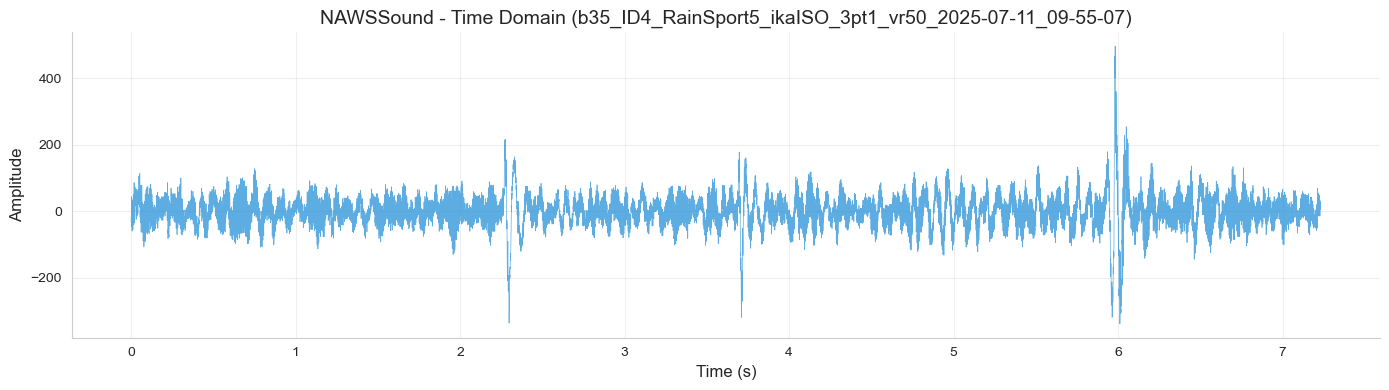

In [ ]:
def plot_time_domain(file_path: str, channel_name: str, title_suffix: str = ""):
    """Plot time-domain signal for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None:
        print(f"Channel {channel_name} not found in file")
        return None

    # Create time axis
    if sample_rate:
        time = np.arange(len(data)) / sample_rate  # type: ignore
        xlabel = "Time (s)"
    else:
        time = np.arange(len(data))  # type: ignore
        xlabel = "Sample"

    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(time, data, linewidth=0.5, color="#3498db", alpha=0.8)  # type: ignore
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Amplitude", fontsize=12)
    ax.set_title(f"{channel_name} - Time Domain {title_suffix}", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    return fig, data, sample_rate


# Plot time domain for available sound channels
sample_file = files_df["file_path"][0]
file_info = Path(sample_file).stem

for ch in available_channels[:4]:  # Plot first 4 channels
    fig, data, sr = plot_time_domain(sample_file, ch["name"], f"({file_info})")  # type: ignore
    plt.show()

## 3. Frequency Spectrum Analysis (FFT)

Analyze the frequency content of tyre noise signals using Fast Fourier Transform.

### Relevance for Road Type Classification
The frequency spectrum is a powerful discriminator for road surface types. Different surfaces excite different frequency bands:

- **Low frequencies (20-200 Hz)**: Dominated by tyre structure vibrations, influenced by road macro-texture (wavelength > 10mm)
- **Mid frequencies (200-1000 Hz)**: Tyre-road interaction noise, sensitive to road mega-texture
- **High frequencies (1000-5000 Hz)**: Air pumping and micro-texture effects

**Classification insights:**
- **Smooth roads**: Energy concentrated in lower frequencies
- **Textured asphalt**: Broader spectral content with mid-frequency emphasis
- **Porous asphalt**: Reduced high-frequency content due to noise absorption
- **Concrete joints**: Periodic spectral peaks from regular surface patterns

The **spectral centroid** (center of mass of spectrum) and **spectral rolloff** are excellent single-value features for ML models.

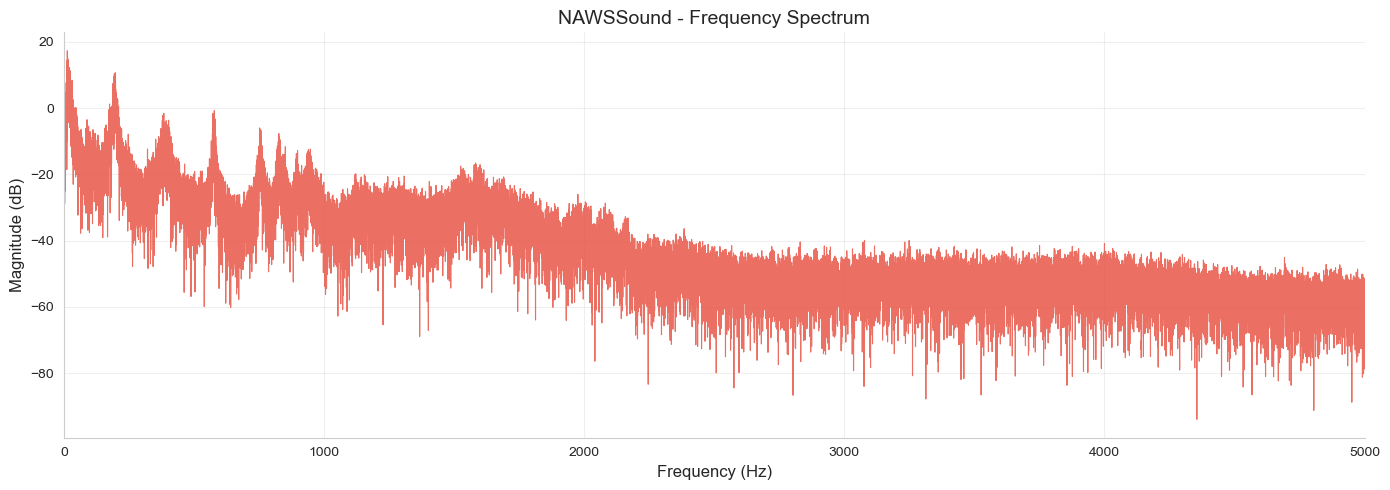

In [ ]:
def compute_fft_spectrum(data: np.ndarray, sample_rate: float):
    """Compute FFT spectrum of the signal."""
    n = len(data)
    # Apply window to reduce spectral leakage
    window = signal.windows.hann(n)  # type: ignore
    windowed_data = data * window

    # Compute FFT
    yf = fft(windowed_data)
    xf = fftfreq(n, 1 / sample_rate)[: n // 2]

    # Convert to magnitude in dB
    magnitude = 2.0 / n * np.abs(yf[0 : n // 2])  # type: ignore
    magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)

    return xf, magnitude_db


def plot_frequency_spectrum(file_path: str, channel_name: str, max_freq: float = None):  # type: ignore
    """Plot frequency spectrum for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute spectrum for {channel_name}")
        return None

    freq, magnitude_db = compute_fft_spectrum(data, sample_rate)  # type: ignore

    if max_freq is None:
        max_freq = sample_rate / 2  # Nyquist frequency

    # Filter to max frequency
    mask = freq <= max_freq
    freq = freq[mask]
    magnitude_db = magnitude_db[mask]

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(freq, magnitude_db, linewidth=0.8, color="#e74c3c", alpha=0.8)
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Magnitude (dB)", fontsize=12)
    ax.set_title(f"{channel_name} - Frequency Spectrum", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, max_freq])  # type: ignore
    plt.tight_layout()

    return fig


# Plot frequency spectra for sound channels (limit to 5kHz for tyre noise)
sample_file = files_df["file_path"][0]

for ch in available_channels[:4]:
    if ch["sample_rate"]:
        fig = plot_frequency_spectrum(sample_file, ch["name"], max_freq=5000)
        plt.show()

## 4. Spectrogram Analysis

Spectrograms show how the frequency content of tyre noise changes over time, which is crucial for understanding dynamic noise patterns.

### Relevance for Road Type Classification
Spectrograms capture **time-varying spectral characteristics** that static FFT analysis misses:

- **Temporal evolution**: Road transitions (e.g., asphalt → concrete) appear as spectral changes over time
- **Pattern recognition**: Regular road features (joints, patches) create repetitive spectral patterns
- **Transient events**: Potholes, cracks, and debris impacts show as broadband impulses

**Classification applications:**
- **CNNs on spectrograms**: Deep learning models can learn visual patterns directly
- **Spectral flux**: Rate of spectral change indicates surface uniformity
- **Harmonic patterns**: Some surfaces create tonal components visible as horizontal lines
- **Feature stability**: Uniform roads show consistent spectral content; variable surfaces show fluctuations

Spectrograms are particularly valuable for **sequence-based models** (RNNs, Transformers) that can learn temporal dependencies.

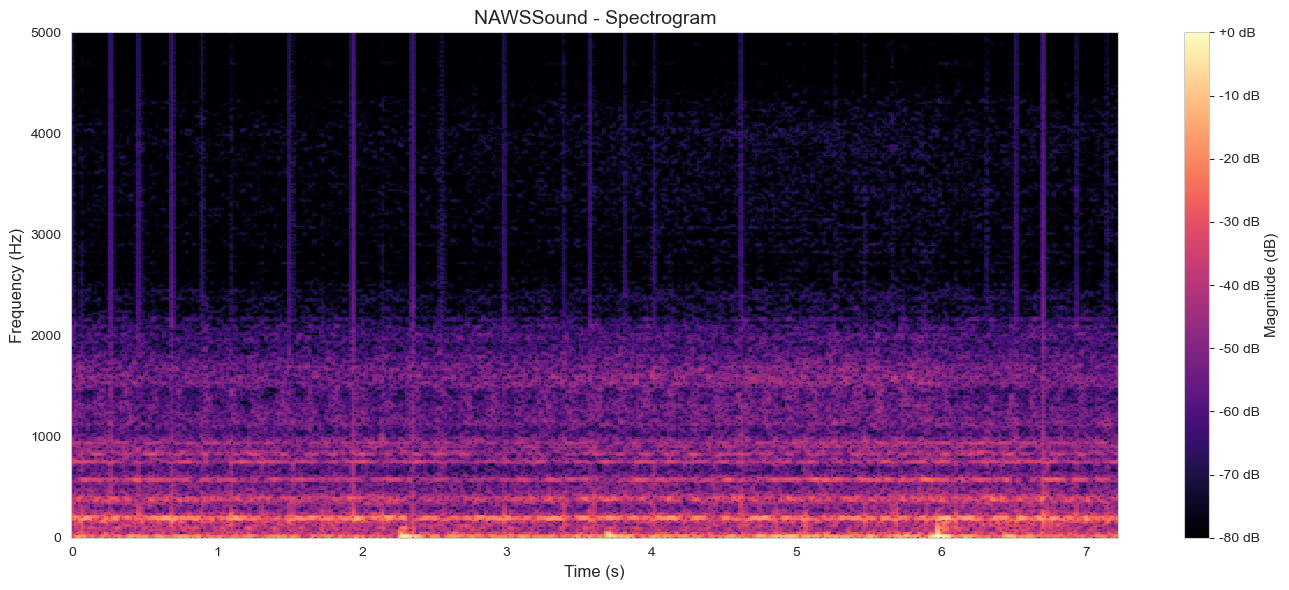

In [ ]:
def plot_spectrogram(
    file_path: str,
    channel_name: str,
    max_freq: float = 5000,
    n_fft: int = 2048,
    hop_length: int = 512,
):
    """Plot spectrogram for a given channel using librosa."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute spectrogram for {channel_name}")
        return None

    # Ensure data is float32
    data = data.astype(np.float32)  # type: ignore

    # Compute Short-Time Fourier Transform
    stft = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)  # type: ignore
    spectrogram_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    fig, ax = plt.subplots(figsize=(14, 6))

    img = librosa.display.specshow(
        spectrogram_db,
        sr=sample_rate,
        hop_length=hop_length,
        x_axis="time",
        y_axis="hz",
        ax=ax,
        cmap="magma",
    )

    ax.set_ylim([0, max_freq])  # type: ignore
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Frequency (Hz)", fontsize=12)
    ax.set_title(f"{channel_name} - Spectrogram", fontsize=14)

    cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label("Magnitude (dB)", fontsize=11)

    plt.tight_layout()
    return fig


# Plot spectrograms for sound channels
sample_file = files_df["file_path"][0]

for ch in available_channels[:4]:
    if ch["sample_rate"]:
        fig = plot_spectrogram(sample_file, ch["name"], max_freq=5000)
        plt.show()

## 5. MFCC (Mel-Frequency Cepstral Coefficients) Analysis

MFCCs are widely used for audio feature extraction. They represent the short-term power spectrum of sound on a mel scale, which approximates human auditory perception. This is particularly useful for:
- Characterizing tyre noise patterns
- Comparing noise signatures across different tyres/vehicles
- Feature extraction for machine learning models

### Relevance for Road Type Classification
MFCCs are among the **most effective features for audio classification** tasks, including road surface recognition:

**Why MFCCs work well:**
1. **Perceptual relevance**: The mel scale mimics human hearing, capturing perceptually important differences
2. **Compact representation**: 13-20 coefficients capture most spectral information
3. **Decorrelated features**: DCT transformation produces uncorrelated features, ideal for many ML algorithms
4. **Robust to amplitude**: Normalized representation reduces sensitivity to recording level

**MFCC interpretation for roads:**
- **MFCC 1**: Overall spectral energy (loudness) - correlates with road roughness
- **MFCC 2-4**: Spectral shape/tilt - distinguishes textured vs smooth surfaces
- **Higher MFCCs**: Fine spectral details - surface material characteristics

**Delta MFCCs** (1st derivative) capture spectral change rate, useful for detecting surface transitions.
**Delta-Delta MFCCs** (2nd derivative) capture acceleration of change, sensitive to impulsive events.

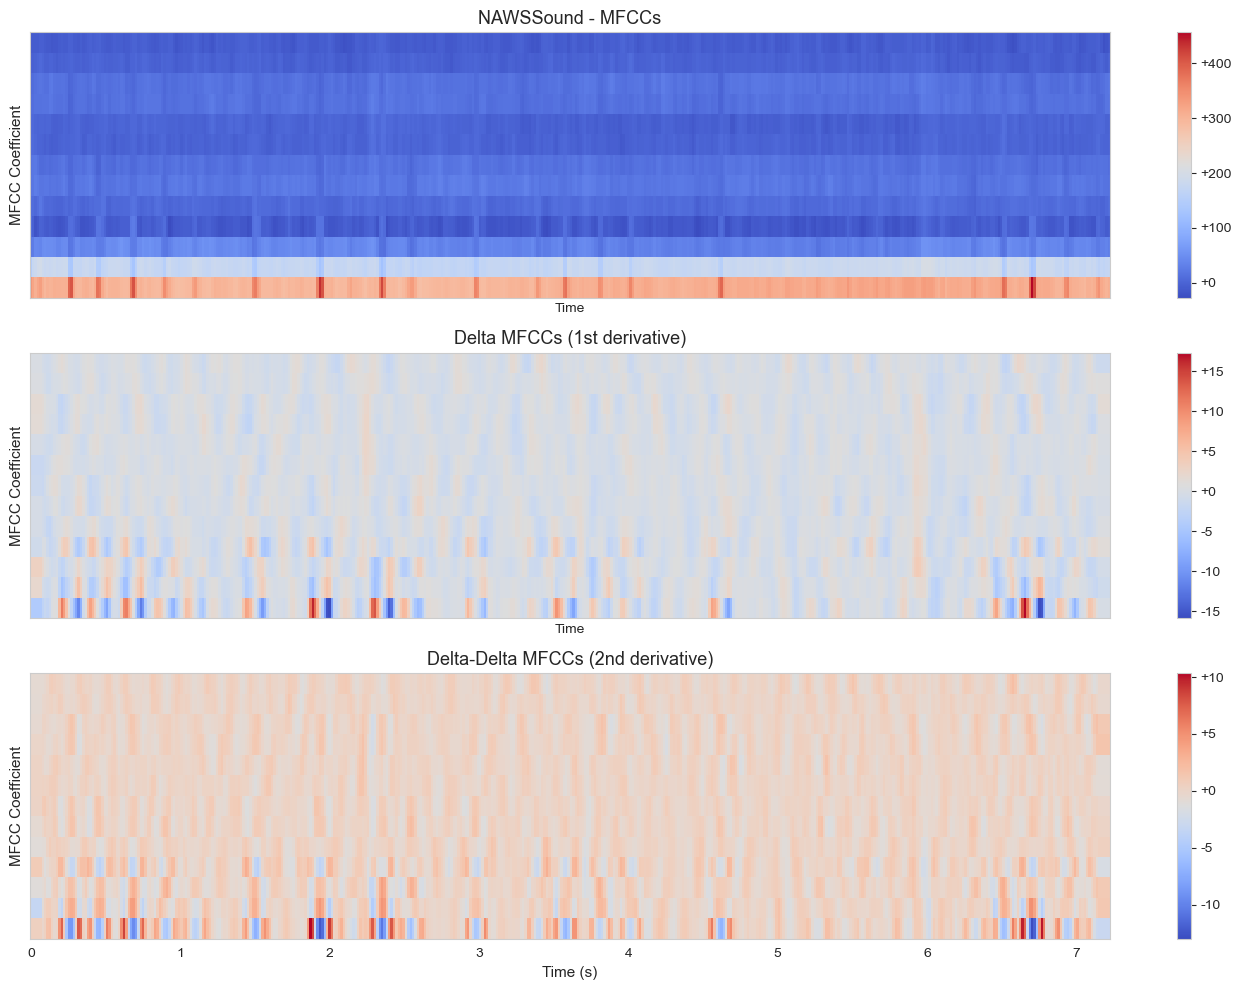

In [ ]:
def compute_mfcc(
    data: np.ndarray, sample_rate: float, n_mfcc: int = 13, n_fft: int = 2048, hop_length: int = 512
):
    """Compute MFCC features for audio data."""
    data = data.astype(np.float32)

    mfccs = librosa.feature.mfcc(
        y=data, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
    )

    # Also compute delta and delta-delta MFCCs for more features
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)

    return mfccs, mfcc_delta, mfcc_delta2


def plot_mfcc(file_path: str, channel_name: str, n_mfcc: int = 13):
    """Plot MFCC features for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute MFCC for {channel_name}")
        return None

    mfccs, mfcc_delta, mfcc_delta2 = compute_mfcc(data, sample_rate, n_mfcc=n_mfcc)  # type: ignore

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Plot MFCCs
    img1 = librosa.display.specshow(
        mfccs, sr=sample_rate, x_axis="time", ax=axes[0], cmap="coolwarm"
    )
    axes[0].set_ylabel("MFCC Coefficient", fontsize=11)
    axes[0].set_title(f"{channel_name} - MFCCs", fontsize=13)
    fig.colorbar(img1, ax=axes[0], format="%+2.0f")

    # Plot Delta MFCCs
    img2 = librosa.display.specshow(
        mfcc_delta, sr=sample_rate, x_axis="time", ax=axes[1], cmap="coolwarm"
    )
    axes[1].set_ylabel("MFCC Coefficient", fontsize=11)
    axes[1].set_title("Delta MFCCs (1st derivative)", fontsize=13)
    fig.colorbar(img2, ax=axes[1], format="%+2.0f")

    # Plot Delta-Delta MFCCs
    img3 = librosa.display.specshow(
        mfcc_delta2, sr=sample_rate, x_axis="time", ax=axes[2], cmap="coolwarm"
    )
    axes[2].set_ylabel("MFCC Coefficient", fontsize=11)
    axes[2].set_xlabel("Time (s)", fontsize=11)
    axes[2].set_title("Delta-Delta MFCCs (2nd derivative)", fontsize=13)
    fig.colorbar(img3, ax=axes[2], format="%+2.0f")

    plt.tight_layout()
    return fig, mfccs


# Plot MFCCs for sound channels
sample_file = files_df["file_path"][0]

for ch in available_channels[:2]:  # Show first 2 channels for brevity
    if ch["sample_rate"]:
        fig, mfccs = plot_mfcc(sample_file, ch["name"])  # type: ignore
        plt.show()

## 6. Mel Spectrogram

The Mel spectrogram applies a perceptually-motivated mel scale to the frequency axis, which better represents how humans perceive sound.

### Relevance for Road Type Classification
Mel spectrograms combine the benefits of spectrograms and mel-scale frequency warping:

**Advantages over linear spectrograms:**
- **Reduced dimensionality**: Fewer mel bands than FFT bins, more efficient for ML
- **Perceptual weighting**: Emphasizes frequencies where tyre noise differences are most audible
- **Better low-frequency resolution**: Critical for capturing road macro-texture effects

**Deep learning applications:**
- **Input for CNNs**: Mel spectrograms are the standard input for audio classification networks
- **Transfer learning**: Pre-trained audio models (AudioSet, VGGish) expect mel spectrogram inputs
- **Attention mechanisms**: Transformers can attend to relevant time-frequency regions

**Road classification insights:**
- Mel bands 1-20 (~20-300 Hz): Road structure vibrations
- Mel bands 20-60 (~300-1500 Hz): Primary tyre-road interaction
- Mel bands 60+ (~1500+ Hz): Air pumping, texture details

The mel spectrogram is often the **best single representation** for end-to-end deep learning classification.

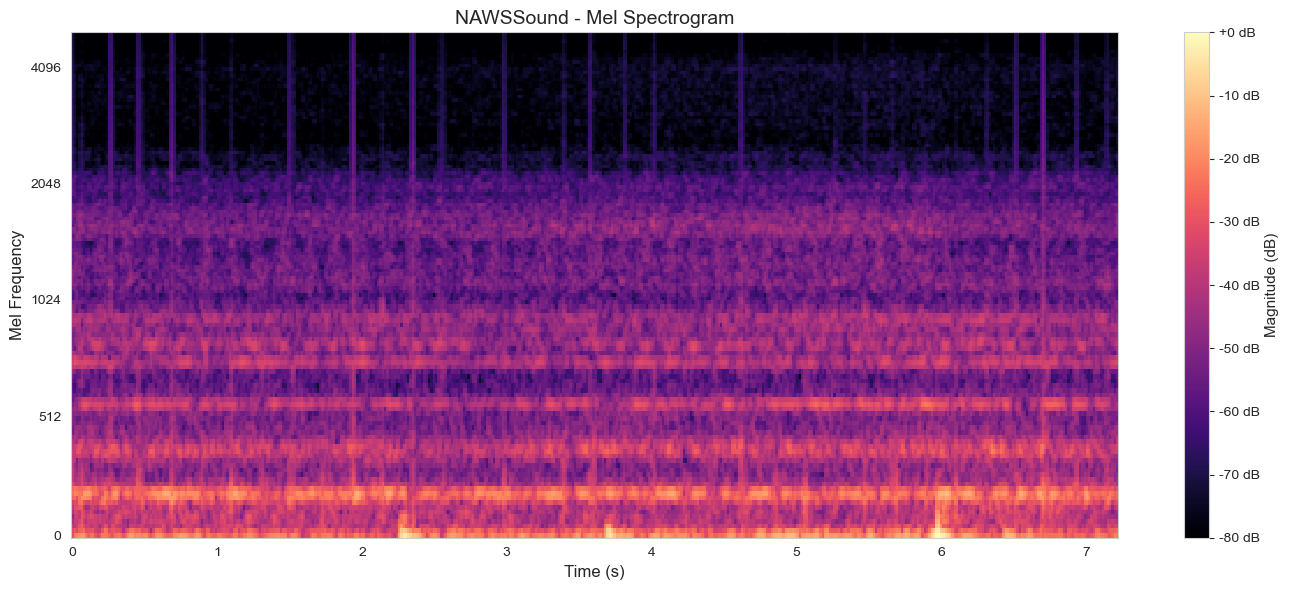

In [ ]:
def plot_mel_spectrogram(
    file_path: str,
    channel_name: str,
    n_mels: int = 128,
    n_fft: int = 2048,
    hop_length: int = 512,
    fmax: float = 5000,
):
    """Plot Mel spectrogram for a given channel."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute Mel spectrogram for {channel_name}")
        return None

    data = data.astype(np.float32)  # type: ignore

    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=data,
        sr=sample_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmax=fmax,  # type: ignore
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    fig, ax = plt.subplots(figsize=(14, 6))

    img = librosa.display.specshow(
        mel_spec_db,
        sr=sample_rate,
        hop_length=hop_length,
        x_axis="time",
        y_axis="mel",
        ax=ax,
        cmap="magma",
        fmax=fmax,
    )

    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Mel Frequency", fontsize=12)
    ax.set_title(f"{channel_name} - Mel Spectrogram", fontsize=14)

    cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label("Magnitude (dB)", fontsize=11)

    plt.tight_layout()
    return fig, mel_spec_db


# Plot Mel spectrograms
sample_file = files_df["file_path"][0]

for ch in available_channels[:2]:
    if ch["sample_rate"]:
        fig, mel_spec = plot_mel_spectrogram(sample_file, ch["name"])  # type: ignore
        plt.show()

## 7. Comparative Analysis Across Vehicles and Tyres

Compare the sound characteristics across different vehicles and tyres to understand how they affect road tyre noise.

### Relevance for Road Type Classification
Understanding **vehicle and tyre variability** is crucial for building robust road classifiers:

**Why this matters:**
- A classifier trained on one vehicle may fail on another
- Tyre properties (size, tread pattern, compound) significantly affect noise signatures
- **Domain adaptation** techniques may be needed for cross-vehicle generalization

**What to look for:**
- **Consistent patterns**: Features that remain stable across vehicles likely reflect road properties
- **Vehicle-specific offsets**: Can be normalized or removed as confounding factors
- **Tyre effects**: Different tread patterns emphasize different frequency ranges

**Classification strategy implications:**
- **Multi-task learning**: Jointly predict road type and vehicle/tyre
- **Feature normalization**: Z-score per vehicle to remove systematic biases
- **Ensemble methods**: Train separate models per vehicle, combine predictions
- **Domain-invariant features**: Focus on relative spectral shapes rather than absolute levels

In [ ]:
def extract_audio_features(file_path: str, channel_name: str):
    """Extract a comprehensive set of audio features for comparison."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        return None

    data = data.astype(np.float32)  # type: ignore

    features = {}

    # Basic statistics
    features["rms"] = np.sqrt(np.mean(data**2))  # type: ignore
    features["peak"] = np.max(np.abs(data))
    features["crest_factor"] = features["peak"] / features["rms"] if features["rms"] > 0 else 0

    # Zero crossing rate (indicator of noise vs tonal content)
    features["zcr_mean"] = np.mean(librosa.feature.zero_crossing_rate(data))  # type: ignore

    # Spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sample_rate)  # type: ignore
    features["spectral_centroid_mean"] = np.mean(spectral_centroid)
    features["spectral_centroid_std"] = np.std(spectral_centroid)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate)  # type: ignore
    features["spectral_bandwidth_mean"] = np.mean(spectral_bandwidth)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)  # type: ignore
    features["spectral_rolloff_mean"] = np.mean(spectral_rolloff)

    # Spectral flatness (measure of noise-like vs tonal)
    spectral_flatness = librosa.feature.spectral_flatness(y=data)  # type: ignore
    features["spectral_flatness_mean"] = np.mean(spectral_flatness)

    # MFCC statistics
    mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)  # type: ignore
    for i in range(13):
        features[f"mfcc_{i + 1}_mean"] = np.mean(mfccs[i])
        features[f"mfcc_{i + 1}_std"] = np.std(mfccs[i])

    return features


# Select one file per vehicle for comparison
vehicle_files = {}
for vehicle in files_df["vehicle"].unique():
    vehicle_file = files_df.filter(pl.col("vehicle") == vehicle)["file_path"][0]
    vehicle_files[vehicle] = vehicle_file

print("Selected files for comparison:")
for v, f in vehicle_files.items():
    print(f"  {v}: {Path(f).name}")

Selected files for comparison:
  02 Audi Q8: track211_Q8 e-tron_tyre12_meas3_2p5_1_2025-08-15_12-50-11.h5
  03 Porsche Taycan: track211_Taycan_tyre10_meas6_2p5_1_2025-09-23_17-14-56.h5
  01 VW ID4: b35_ID4_RainSport5_ikaISO_3pt1_vr50_2025-07-11_09-55-07.h5
  04 VW eGolf: track211_E-Golf_tyre13_meas3_2p5_1_2025-09-26_14-53-31.h5


### 7.1 Frequency Spectrum Comparison

This plot overlays frequency spectra from different vehicles to identify common patterns and vehicle-specific variations.

**Classification relevance:**
- Frequencies where all vehicles show similar patterns are **road-dependent**
- Frequencies with high vehicle variance are **vehicle-dependent** and may need normalization

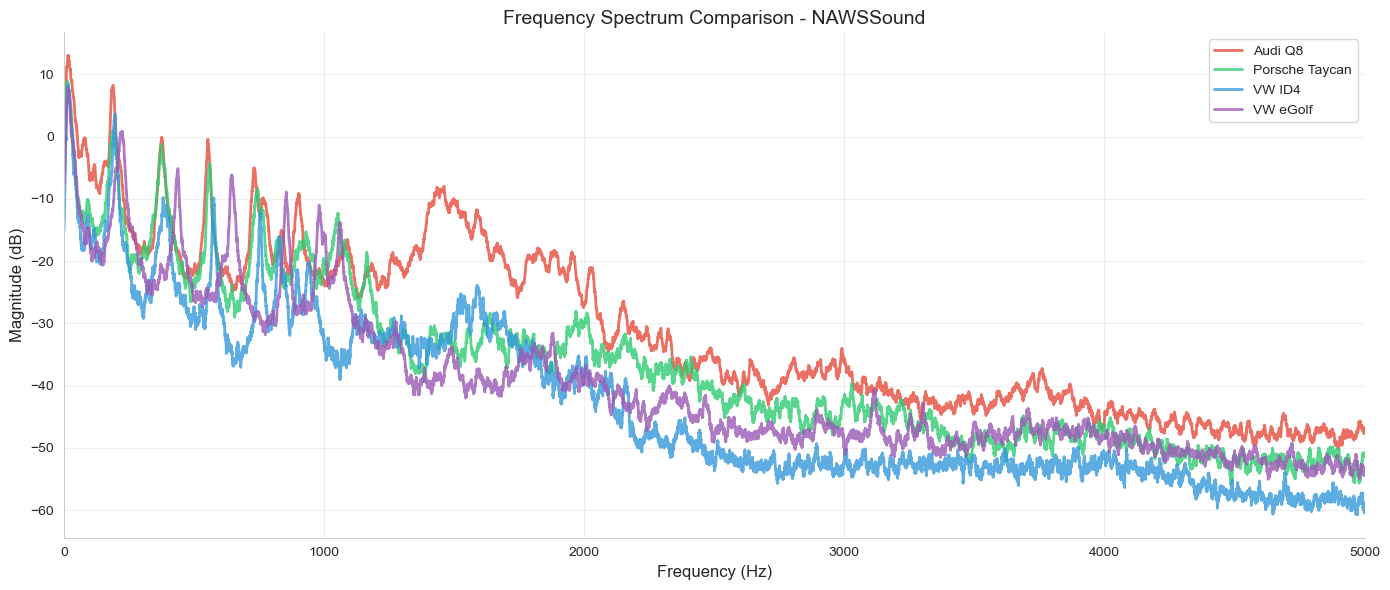

In [ ]:
# Extract features for each vehicle and compare
def compare_vehicles_spectrum(vehicle_files: dict, channel_name: str, max_freq: float = 5000):
    """Compare frequency spectra across different vehicles."""
    fig, ax = plt.subplots(figsize=(14, 6))

    for vehicle, file_path in vehicle_files.items():
        data, sample_rate = load_h5_dataset(file_path, channel_name)
        if data is None or sample_rate is None:
            continue

        freq, magnitude_db = compute_fft_spectrum(data, sample_rate)  # type: ignore

        # Filter and smooth for better visualization
        mask = freq <= max_freq
        freq = freq[mask]
        magnitude_db = magnitude_db[mask]

        # Apply smoothing
        from scipy.ndimage import uniform_filter1d

        magnitude_smooth = uniform_filter1d(magnitude_db, size=50)

        color = VEHICLE_COLORS.get(vehicle, "#95a5a6")
        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle
        ax.plot(freq, magnitude_smooth, linewidth=2, color=color, label=label, alpha=0.8)

    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Magnitude (dB)", fontsize=12)
    ax.set_title(f"Frequency Spectrum Comparison - {channel_name}", fontsize=14)
    ax.legend(loc="upper right", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, max_freq])  # type: ignore
    plt.tight_layout()

    return fig


# Compare vehicles using the first available sound channel
if available_channels:
    channel_to_compare = available_channels[0]["name"]
    fig = compare_vehicles_spectrum(vehicle_files, channel_to_compare)
    plt.show()

### 7.2 MFCC Profile Comparison

Comparing MFCC heatmaps across vehicles reveals how each vehicle's acoustic signature differs over time.

**Classification relevance:**
- Similar MFCC patterns across vehicles on the same road indicate **road-specific features**
- Vehicle-specific MFCC variations suggest the need for **vehicle-aware models** or normalization strategies

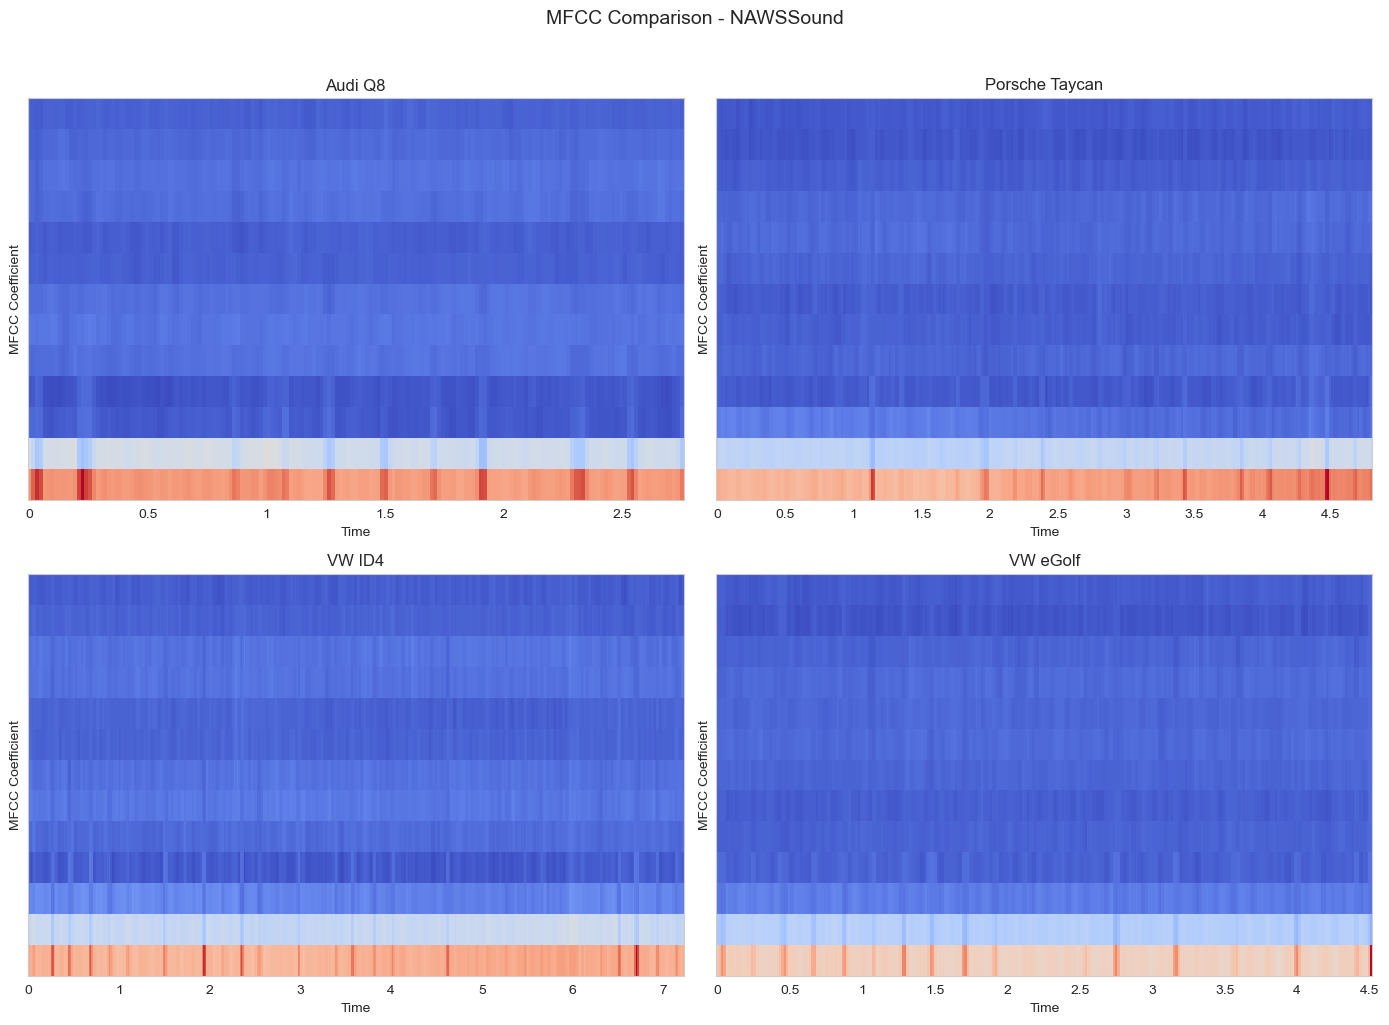

In [ ]:
# Compare MFCCs across vehicles
def compare_mfcc_profiles(vehicle_files: dict, channel_name: str):
    """Compare average MFCC profiles across vehicles."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    mfcc_means = {}

    for idx, (vehicle, file_path) in enumerate(vehicle_files.items()):
        if idx >= 4:  # Limit to 4 vehicles for layout
            break

        data, sample_rate = load_h5_dataset(file_path, channel_name)
        if data is None or sample_rate is None:
            continue

        data = data.astype(np.float32)  # type: ignore
        mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)  # type: ignore

        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle

        # Store mean MFCC for comparison
        mfcc_means[vehicle] = np.mean(mfccs, axis=1)

        # Plot MFCC for each vehicle
        librosa.display.specshow(
            mfccs, sr=sample_rate, x_axis="time", ax=axes[idx], cmap="coolwarm"
        )
        axes[idx].set_title(f"{label}", fontsize=12)
        axes[idx].set_ylabel("MFCC Coefficient")

    plt.suptitle(f"MFCC Comparison - {channel_name}", fontsize=14, y=1.02)
    plt.tight_layout()

    return fig, mfcc_means


if available_channels:
    channel_to_compare = available_channels[0]["name"]
    fig, mfcc_means = compare_mfcc_profiles(vehicle_files, channel_to_compare)
    plt.show()

## 8. Feature Summary Statistics

Extract and visualize key audio features across all measurements for a comprehensive overview.

### Relevance for Road Type Classification
Statistical summaries across multiple measurements help identify **robust features** for classification:

**Boxplots reveal:**
- **Inter-class separation**: Features with non-overlapping boxes between road types are good discriminators
- **Intra-class variance**: Tight boxes indicate consistent features; wide boxes suggest variability
- **Outliers**: May indicate measurement issues or unusual road conditions

**Key features for road classification:**
- **Spectral centroid**: Higher for rough/textured surfaces
- **Spectral bandwidth**: Broader for surfaces with varied texture
- **Spectral rolloff**: Indicates where most energy is concentrated
- **Spectral flatness**: Higher for noise-like signals (rough roads), lower for tonal (smooth)
- **Zero crossing rate**: Higher for high-frequency content (textured surfaces)
- **RMS energy**: Direct measure of overall noise level

In [ ]:
# Build channel synonym mapping from CSV
def build_channel_synonym_map(channels_df: pl.DataFrame) -> dict:
    """Build a mapping from channel names to their synonyms."""
    synonym_map = {}
    for row in channels_df.iter_rows(named=True):
        channel_name = row.get("channel_name", "")
        if not channel_name:
            continue

        # Build list of all names for this channel (main + synonyms)
        all_names = [channel_name]
        if row.get("synonym_1") and str(row.get("synonym_1")) not in ["", "None"]:
            all_names.append(str(row.get("synonym_1")))
        if row.get("synonym_2") and str(row.get("synonym_2")) not in ["", "None"]:
            all_names.append(str(row.get("synonym_2")))

        # Map each name to all possible names
        for name in all_names:
            synonym_map[name] = all_names

    return synonym_map


# Create the synonym map
CHANNEL_SYNONYMS = build_channel_synonym_map(all_channel_names)

# Show relevant sound channel synonyms
print("Sound channel synonyms from CSV:")
for ch in ["Ch_1_labV12", "Ch_2_labV12", "Ch_3_labV12", "Ch_4_labV12", "NAWSSound", "mic_iso"]:
    if ch in CHANNEL_SYNONYMS:
        print(f"  {ch}: {CHANNEL_SYNONYMS[ch]}")


# Extract features from all files (sample for efficiency)
def extract_features_from_files(
    files_df: pl.DataFrame,
    channel_pattern: str,
    max_files: int = 50,
    synonym_map: dict = None,  # type: ignore
):
    """Extract audio features from multiple files.

    Uses synonym_map to find equivalent channel names when the primary pattern is not found.
    Only extracts from files that have the specified channel (or its synonyms).
    """
    all_features = []

    # Sample files if too many
    if len(files_df) > max_files:
        sample_df = files_df.sample(n=max_files, seed=42)
    else:
        sample_df = files_df

    # Build list of patterns to search for (main + synonyms)
    patterns_to_try = [channel_pattern]
    if synonym_map and channel_pattern in synonym_map:
        patterns_to_try = synonym_map[channel_pattern]

    print(f"Searching for channel patterns: {patterns_to_try}")

    for row in sample_df.iter_rows(named=True):
        file_path = row["file_path"]

        # Find matching channel - try each pattern in order
        channels = get_available_sound_channels(file_path)
        matching_channel = None

        for pattern in patterns_to_try:
            matching = [c for c in channels if pattern in c["name"]]
            if matching:
                matching_channel = matching[0]["name"]
                break

        if not matching_channel:
            continue

        features = extract_audio_features(file_path, matching_channel)

        if features:
            features["file_path"] = file_path
            features["vehicle"] = row["vehicle"]
            features["tyre_ID"] = row["tyre_ID"]
            features["track_ID"] = row["track_ID"]
            features["channel_used"] = matching_channel
            all_features.append(features)

    return pl.DataFrame(all_features)


# Extract features using NAWSSound - the only channel available for ALL vehicles
print("\nExtracting audio features from files using NAWSSound...")
features_df = extract_features_from_files(
    files_df,
    "NAWSSound",  # Use NAWSSound for fair comparison across all vehicles
    max_files=50,
    synonym_map=CHANNEL_SYNONYMS,
)
print(f"\nExtracted features from {len(features_df)} files")
print(f"Vehicles in features_df: {features_df['vehicle'].unique().to_list()}")
print(
    f"Channels used: {features_df['channel_used'].unique().to_list() if 'channel_used' in features_df.columns else 'N/A'}"
)
features_df.head()

Sound channel synonyms from CSV:
  Ch_1_labV12: ['Ch_1_labV12', 'TrailK1']
  Ch_2_labV12: ['Ch_2_labV12', 'TrailK2']
  Ch_3_labV12: ['Ch_3_labV12', 'LeadK1']
  Ch_4_labV12: ['Ch_4_labV12', 'LeadK2']
  NAWSSound: ['NAWSSound']
  mic_iso: ['mic_iso']

Extracting audio features from files using NAWSSound...
Searching for channel patterns: ['NAWSSound']

Extracted features from 49 files
Vehicles in features_df: ['03 Porsche Taycan', '02 Audi Q8', '04 VW eGolf', '01 VW ID4']
Channels used: ['NAWSSound']

Extracted features from 49 files
Vehicles in features_df: ['03 Porsche Taycan', '02 Audi Q8', '04 VW eGolf', '01 VW ID4']
Channels used: ['NAWSSound']


rms,peak,crest_factor,zcr_mean,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_rolloff_mean,spectral_flatness_mean,mfcc_1_mean,mfcc_1_std,mfcc_2_mean,mfcc_2_std,mfcc_3_mean,mfcc_3_std,mfcc_4_mean,mfcc_4_std,mfcc_5_mean,mfcc_5_std,mfcc_6_mean,mfcc_6_std,mfcc_7_mean,mfcc_7_std,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std,file_path,vehicle,tyre_ID,track_ID,channel_used
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64,i64,str
40.729969,504.166229,12.378262,0.020992,760.290216,305.542487,1553.249863,1135.139173,0.00042,313.581757,23.303679,181.204498,11.063271,42.35693,7.625542,1.789871,7.797145,0.833849,4.510868,-2.273221,4.495471,5.577747,3.835555,10.5834,4.050914,8.359807,3.702995,11.668988,4.731977,2.294427,4.173761,-14.878482,4.657568,-7.191393,3.971017,"""/Users/moritzfeik/Developer/RO…","""04 VW eGolf""",13,150,"""NAWSSound"""
45.642841,476.93811,10.449352,0.015672,728.974812,339.241504,1564.102556,1161.509901,0.000371,296.509399,31.50038,161.818787,8.886943,48.974434,9.396707,3.67525,7.623394,-0.731942,4.869508,1.584851,4.855405,7.469056,3.984482,10.869092,4.109087,10.844127,4.047472,11.428748,4.028867,0.651905,3.669119,-14.184554,5.450852,-7.606935,4.421096,"""/Users/moritzfeik/Developer/RO…","""04 VW eGolf""",13,211,"""NAWSSound"""
49.200752,542.215942,11.020481,0.01576,749.571965,360.993137,1564.590451,1192.893401,0.000487,315.334991,22.438803,169.96579,10.135712,40.184765,7.044639,0.716222,7.208567,7.652957,4.041654,3.398776,4.074952,-0.886075,4.494012,9.266896,3.798019,16.448696,4.748155,11.382296,4.341441,0.419935,4.204319,-6.76529,4.596125,-4.231278,3.704038,"""/Users/moritzfeik/Developer/RO…","""03 Porsche Taycan""",10,150,"""NAWSSound"""
52.242718,548.117981,10.491758,0.014606,753.330772,363.204511,1578.699868,1205.221861,0.000427,318.37323,24.544212,170.788895,11.222538,36.367329,6.774251,2.596809,7.937316,9.519369,4.539837,1.835628,4.196693,-0.307641,4.588201,10.758002,4.200386,16.063358,5.022644,11.772533,4.292484,1.472863,4.139145,-6.788513,4.655609,-4.146955,3.739964,"""/Users/moritzfeik/Developer/RO…","""03 Porsche Taycan""",10,211,"""NAWSSound"""
40.533634,461.071808,11.375042,0.01973,769.40018,355.192466,1595.042962,1170.738078,0.0005,311.474792,31.341095,173.951935,13.297475,47.160313,11.485977,3.558743,8.389592,-0.638814,4.609688,-1.513175,5.142902,5.45628,4.306844,10.505644,4.055074,9.92509,4.278859,11.130149,4.738106,1.003125,4.127026,-14.094078,5.298133,-7.427775,4.187474,"""/Users/moritzfeik/Developer/RO…","""04 VW eGolf""",13,150,"""NAWSSound"""


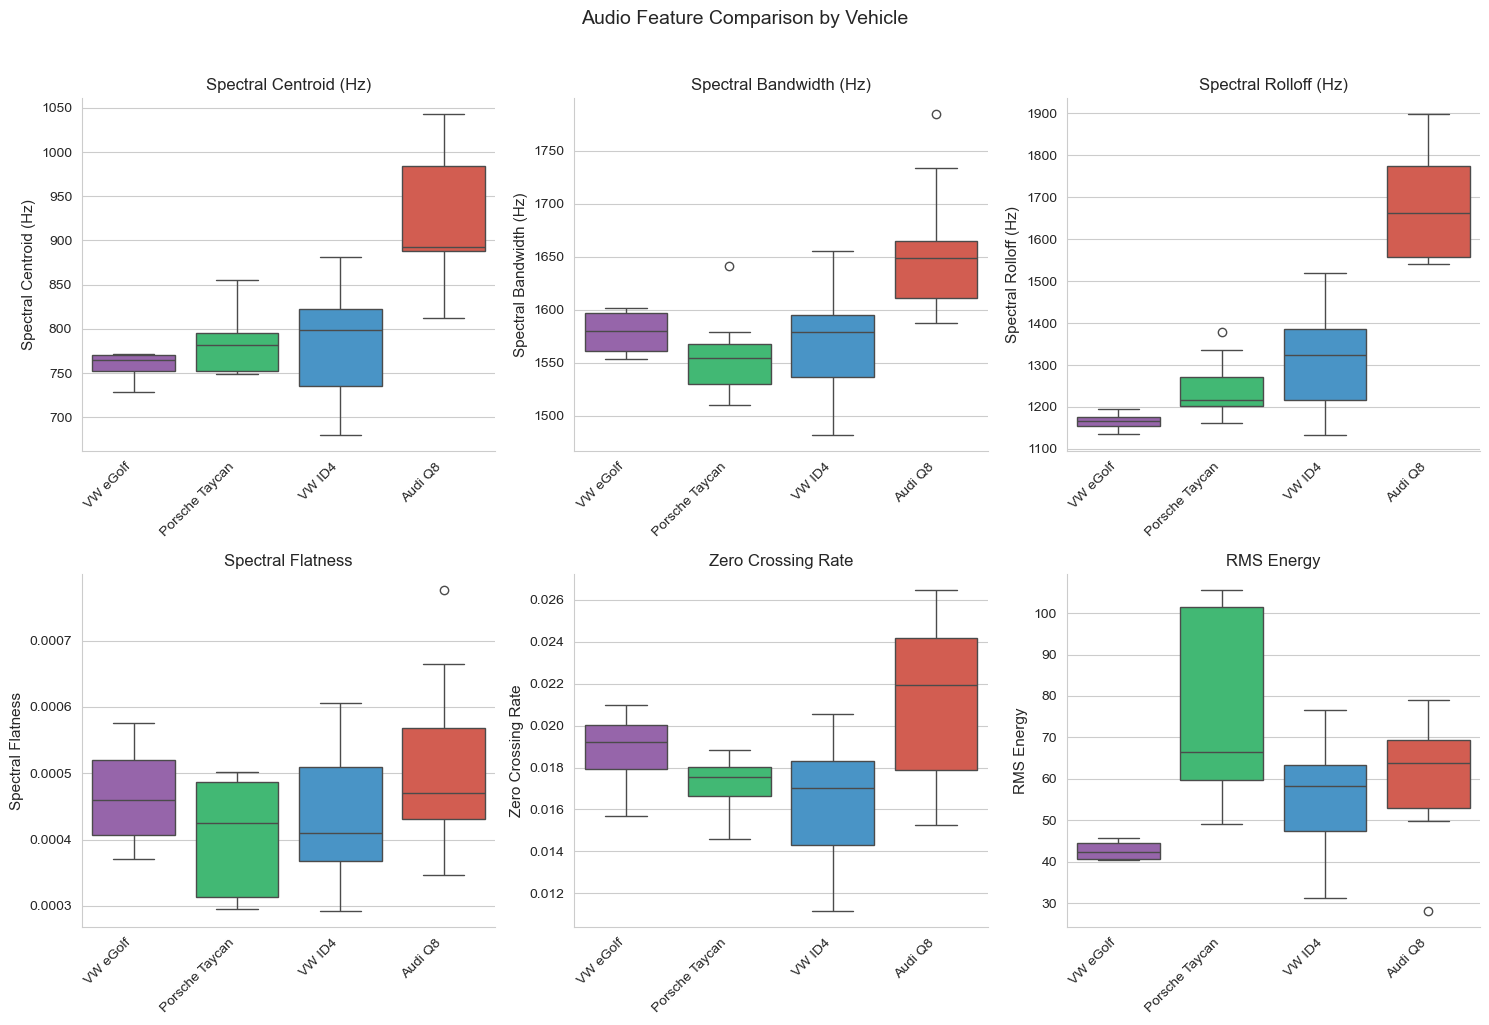

In [18]:
# Visualize feature distributions by vehicle
def plot_feature_comparison(features_df: pl.DataFrame):
    """Plot comparison of key audio features across vehicles."""
    key_features = [
        "spectral_centroid_mean",
        "spectral_bandwidth_mean",
        "spectral_rolloff_mean",
        "spectral_flatness_mean",
        "zcr_mean",
        "rms",
    ]

    feature_labels = {
        "spectral_centroid_mean": "Spectral Centroid (Hz)",
        "spectral_bandwidth_mean": "Spectral Bandwidth (Hz)",
        "spectral_rolloff_mean": "Spectral Rolloff (Hz)",
        "spectral_flatness_mean": "Spectral Flatness",
        "zcr_mean": "Zero Crossing Rate",
        "rms": "RMS Energy",
    }

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    pdf = features_df.to_pandas()

    for idx, feature in enumerate(key_features):
        if feature not in pdf.columns:
            continue

        ax = axes[idx]

        sns.boxplot(data=pdf, x="vehicle", y=feature, palette=VEHICLE_COLORS, ax=ax)

        ax.set_xlabel("")
        ax.set_ylabel(feature_labels.get(feature, feature), fontsize=11)
        ax.set_title(feature_labels.get(feature, feature), fontsize=12)

        # Clean up x-axis labels
        labels = [
            label.get_text().split(" ", 1)[1] if " " in label.get_text() else label.get_text()
            for label in ax.get_xticklabels()
        ]
        ax.set_xticklabels(labels, rotation=45, ha="right")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.suptitle("Audio Feature Comparison by Vehicle", fontsize=14, y=1.02)
    plt.tight_layout()
    return fig


if len(features_df) > 0:
    fig = plot_feature_comparison(features_df)
    plt.show()

### 8.1 Feature Distribution Boxplots

These boxplots show the distribution of key spectral features across different vehicles, helping identify which features vary more due to vehicle vs road properties.

**For road type prediction:**
- Features with **small within-vehicle variance** but **large between-road variance** are ideal
- Use these plots to select features for your classification model

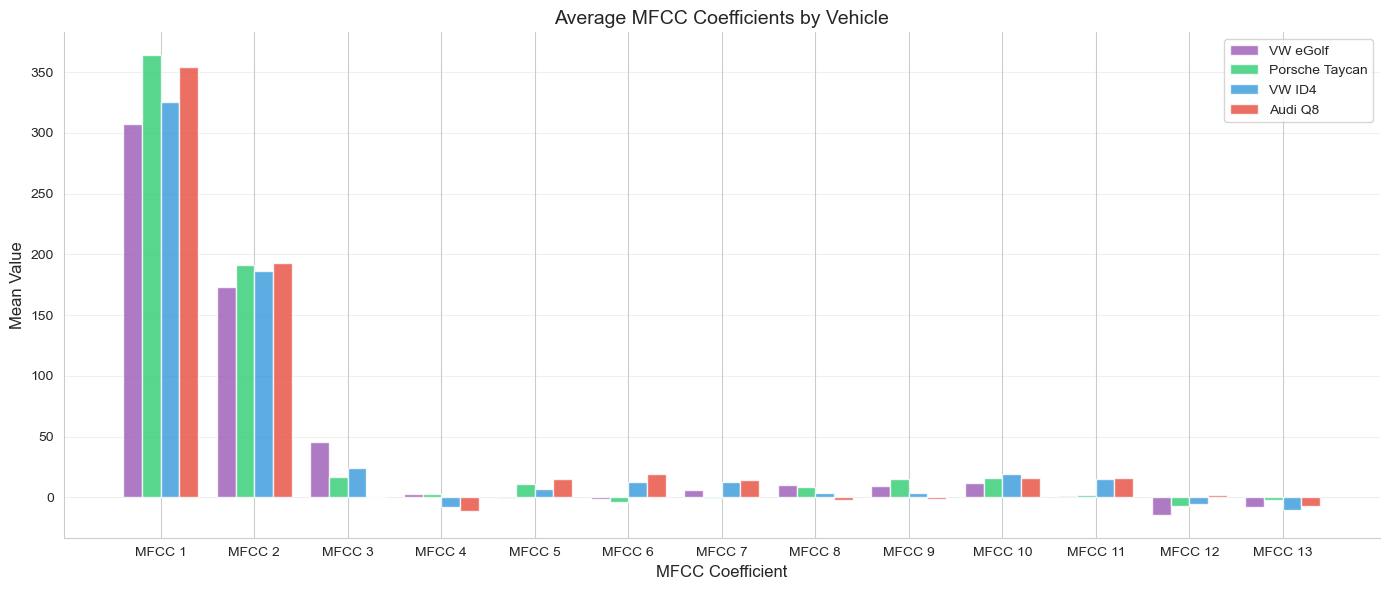

In [19]:
# Plot MFCC feature comparison by vehicle
def plot_mfcc_comparison(features_df: pl.DataFrame):
    """Plot mean MFCC coefficients by vehicle."""
    mfcc_cols = [f"mfcc_{i}_mean" for i in range(1, 14)]

    # Check which columns exist
    existing_cols = [col for col in mfcc_cols if col in features_df.columns]
    if not existing_cols:
        print("No MFCC features available")
        return None

    pdf = features_df.to_pandas()

    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(existing_cols))
    width = 0.2

    vehicles = pdf["vehicle"].unique()

    for idx, vehicle in enumerate(vehicles):
        vehicle_data = pdf[pdf["vehicle"] == vehicle]
        mfcc_means = [vehicle_data[col].mean() for col in existing_cols]

        color = VEHICLE_COLORS.get(vehicle, "#95a5a6")
        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle

        ax.bar(x + idx * width, mfcc_means, width, label=label, color=color, alpha=0.8)

    ax.set_xlabel("MFCC Coefficient", fontsize=12)
    ax.set_ylabel("Mean Value", fontsize=12)
    ax.set_title("Average MFCC Coefficients by Vehicle", fontsize=14)
    ax.set_xticks(x + width * (len(vehicles) - 1) / 2)
    ax.set_xticklabels([f"MFCC {i}" for i in range(1, len(existing_cols) + 1)])
    ax.legend(loc="upper right", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    return fig


if len(features_df) > 0:
    fig = plot_mfcc_comparison(features_df)
    plt.show()

### 8.2 MFCC Coefficient Comparison

This bar chart compares mean MFCC values across vehicles, showing which coefficients vary most.

**For road type prediction:**
- **MFCC 1** (highest values): Represents overall energy/loudness
- **MFCC 2-4**: Capture spectral tilt and broad shape - often most discriminative
- **Higher MFCCs**: Fine spectral details, may be more noise-sensitive

Select MFCCs where **road type differences exceed vehicle differences** for robust classification.

## 9. Octave Band Analysis

Octave band analysis is commonly used in acoustics to analyze noise levels across standard frequency bands. This is particularly relevant for tyre noise regulations and characterization.

### Relevance for Road Type Classification
1/3 octave band analysis provides **standardized frequency band levels** used in acoustic engineering:

**Why octave bands matter:**
- **Industry standard**: Acoustic measurements and regulations use octave bands
- **Interpretable**: Each band corresponds to a known frequency range
- **Reduced dimensionality**: 25 bands vs thousands of FFT bins
- **Noise-robust**: Band energy averages out fine spectral variations

**Road type signatures in octave bands:**
- **25-100 Hz**: Structural vibrations, suspension response to macro-texture
- **100-500 Hz**: Primary tyre noise generation, road mega-texture
- **500-2000 Hz**: Air pumping mechanism, micro-texture effects
- **2000-5000 Hz**: High-frequency texture noise, often absorbed by porous surfaces

**Classification approach:**
- Octave band levels can be directly used as a **25-dimensional feature vector**
- **Band ratios** (e.g., low/high frequency) are vehicle-independent features
- **Spectral slope** across bands indicates surface type

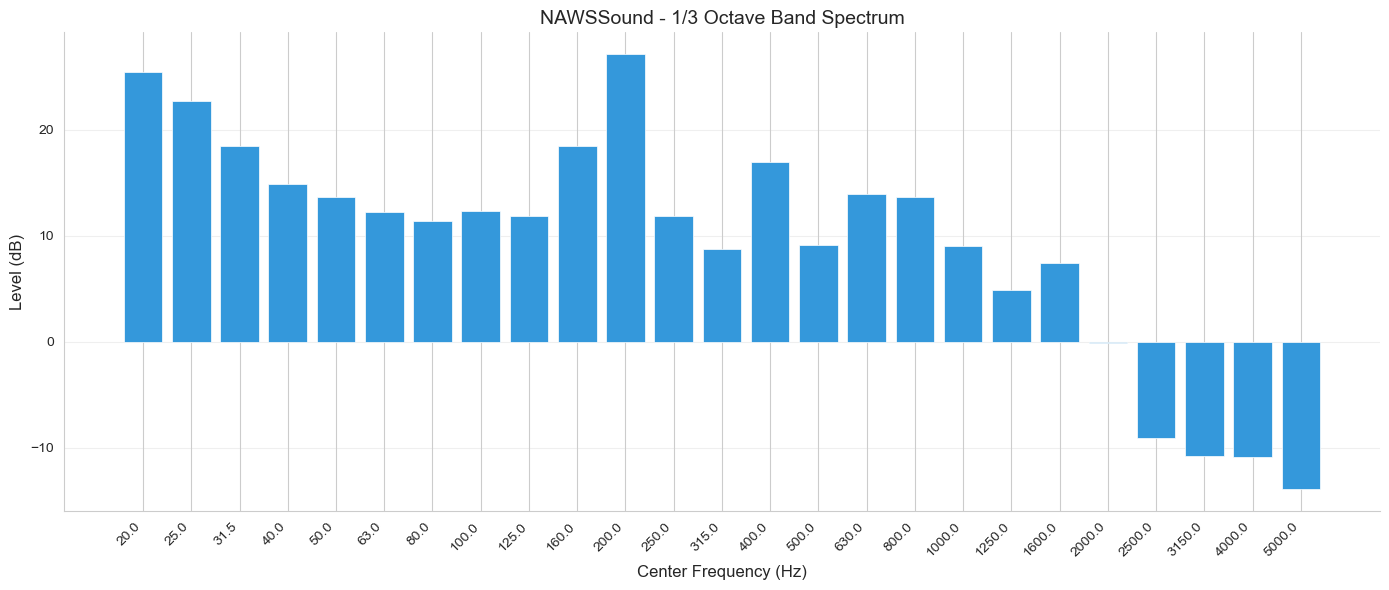

In [ ]:
# Standard 1/3 octave band center frequencies (Hz)
OCTAVE_BANDS = [
    20,
    25,
    31.5,
    40,
    50,
    63,
    80,
    100,
    125,
    160,
    200,
    250,
    315,
    400,
    500,
    630,
    800,
    1000,
    1250,
    1600,
    2000,
    2500,
    3150,
    4000,
    5000,
]


def compute_octave_band_levels(data: np.ndarray, sample_rate: float, bands: list = OCTAVE_BANDS):
    """Compute 1/3 octave band levels."""
    band_levels = []

    for fc in bands:
        if fc > sample_rate / 2:
            band_levels.append(np.nan)
            continue

        # 1/3 octave band edges
        f_low = fc / (2 ** (1 / 6))
        f_high = fc * (2 ** (1 / 6))

        # Ensure within Nyquist
        f_high = min(f_high, sample_rate / 2 * 0.99)

        if f_low >= sample_rate / 2:
            band_levels.append(np.nan)
            continue

        # Design bandpass filter
        try:
            sos = signal.butter(4, [f_low, f_high], btype="band", fs=sample_rate, output="sos")
            filtered = signal.sosfilt(sos, data)

            # Compute RMS level in dB
            rms = np.sqrt(np.mean(filtered**2))  # type: ignore
            level_db = 20 * np.log10(rms + 1e-10)
            band_levels.append(level_db)
        except Exception:
            band_levels.append(np.nan)

    return np.array(band_levels)


def plot_octave_bands(file_path: str, channel_name: str):
    """Plot 1/3 octave band spectrum."""
    data, sample_rate = load_h5_dataset(file_path, channel_name)

    if data is None or sample_rate is None:
        print(f"Cannot compute octave bands for {channel_name}")
        return None

    levels = compute_octave_band_levels(data, sample_rate)  # type: ignore

    fig, ax = plt.subplots(figsize=(14, 6))

    valid_mask = ~np.isnan(levels)
    valid_bands = np.array(OCTAVE_BANDS)[valid_mask]
    valid_levels = levels[valid_mask]

    ax.bar(
        range(len(valid_levels)), valid_levels, color="#3498db", edgecolor="white", linewidth=0.5
    )
    ax.set_xticks(range(len(valid_levels)))
    ax.set_xticklabels([f"{b}" for b in valid_bands], rotation=45, ha="right")
    ax.set_xlabel("Center Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Level (dB)", fontsize=12)
    ax.set_title(f"{channel_name} - 1/3 Octave Band Spectrum", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    return fig


# Plot octave band analysis
sample_file = files_df["file_path"][0]
if available_channels:
    fig = plot_octave_bands(sample_file, available_channels[0]["name"])
    plt.show()

### 9.1 Single Measurement Octave Bands

This bar chart shows the 1/3 octave band spectrum for a single measurement, revealing the energy distribution across standardized frequency bands.

**For road classification:**
- The **shape** of the octave band spectrum is characteristic of road surface type
- Peaks and valleys indicate resonances and absorption properties of the road

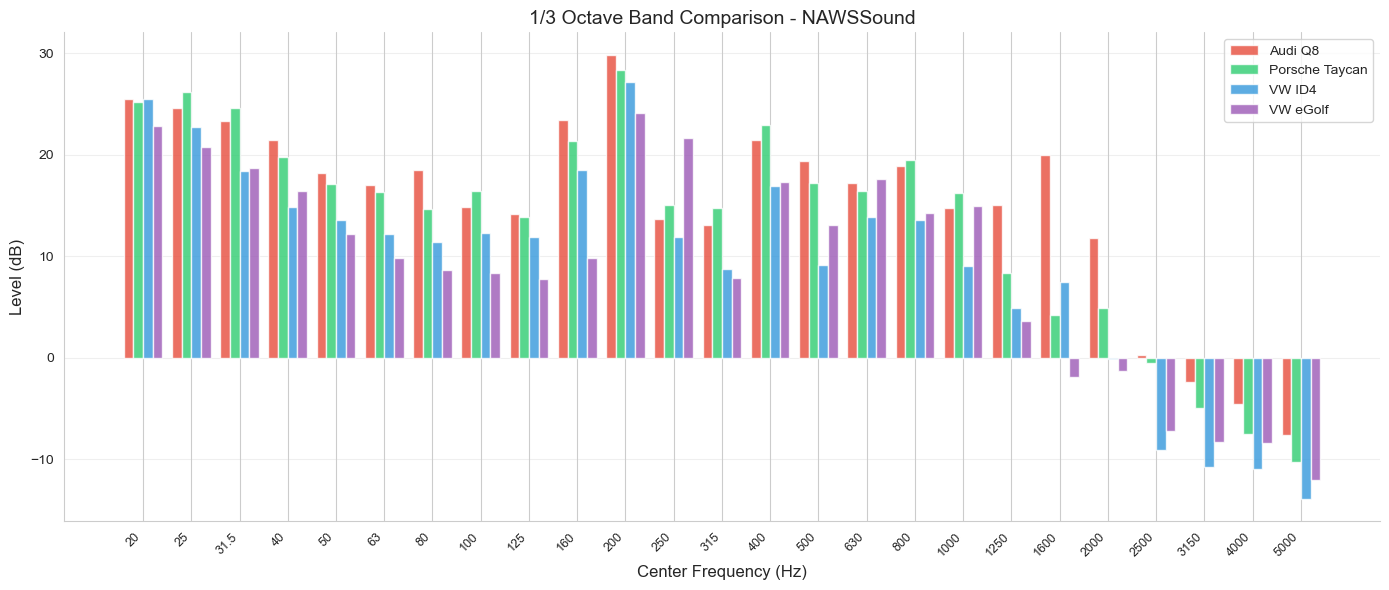

In [ ]:
# Compare octave band spectra across vehicles
def compare_octave_bands(vehicle_files: dict, channel_name: str):
    """Compare 1/3 octave band spectra across vehicles."""
    fig, ax = plt.subplots(figsize=(14, 6))

    all_levels = {}

    for vehicle, file_path in vehicle_files.items():
        data, sample_rate = load_h5_dataset(file_path, channel_name)
        if data is None or sample_rate is None:
            continue

        levels = compute_octave_band_levels(data, sample_rate)  # type: ignore
        all_levels[vehicle] = levels

    x = np.arange(len(OCTAVE_BANDS))
    width = 0.2

    for idx, (vehicle, levels) in enumerate(all_levels.items()):
        color = VEHICLE_COLORS.get(vehicle, "#95a5a6")
        label = vehicle.split(" ", 1)[1] if " " in vehicle else vehicle

        # Handle NaN values
        valid_levels = np.nan_to_num(levels, nan=-100)
        ax.bar(x + idx * width, valid_levels, width, label=label, color=color, alpha=0.8)

    ax.set_xticks(x + width * (len(all_levels) - 1) / 2)
    ax.set_xticklabels([f"{b}" for b in OCTAVE_BANDS], rotation=45, ha="right", fontsize=9)
    ax.set_xlabel("Center Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Level (dB)", fontsize=12)
    ax.set_title(f"1/3 Octave Band Comparison - {channel_name}", fontsize=14)
    ax.legend(loc="upper right", fontsize=10)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    return fig


if available_channels:
    fig = compare_octave_bands(vehicle_files, available_channels[0]["name"])
    plt.show()

### 9.2 Octave Band Comparison Across Vehicles

Comparing octave band spectra across vehicles reveals which frequency bands are vehicle-dependent vs road-dependent.

**For road classification:**
- Bands with **consistent patterns** across vehicles likely encode road information
- **Relative band levels** (normalized spectra) may be more vehicle-independent than absolute levels

## 10. Feature Correlation Analysis

Analyze correlations between different audio features to understand their relationships and potential redundancies.

### Relevance for Road Type Classification
Understanding feature correlations is essential for **feature selection** and **model design**:

**Why correlation analysis matters:**
1. **Redundancy detection**: Highly correlated features provide similar information
2. **Dimensionality reduction**: Remove redundant features or use PCA
3. **Multicollinearity**: Correlated features can destabilize linear models
4. **Feature engineering**: Low-correlation features can be combined for new insights

**What to look for:**
- **High correlation (|r| > 0.8)**: Consider keeping only one feature from highly correlated pairs
- **Moderate correlation (0.5 < |r| < 0.8)**: Features capture related but distinct information
- **Low correlation (|r| < 0.5)**: Independent features, good candidates for ensemble

**Expected patterns:**
- RMS and spectral centroid often correlate (louder signals tend to have more high-frequency content)
- MFCCs are designed to be uncorrelated (DCT decorrelation)
- Spectral bandwidth and rolloff typically correlate (both measure spectral spread)

**For classification:**
- Select a **diverse, uncorrelated feature set** for best model performance
- Use **regularization** (L1/L2) if including correlated features

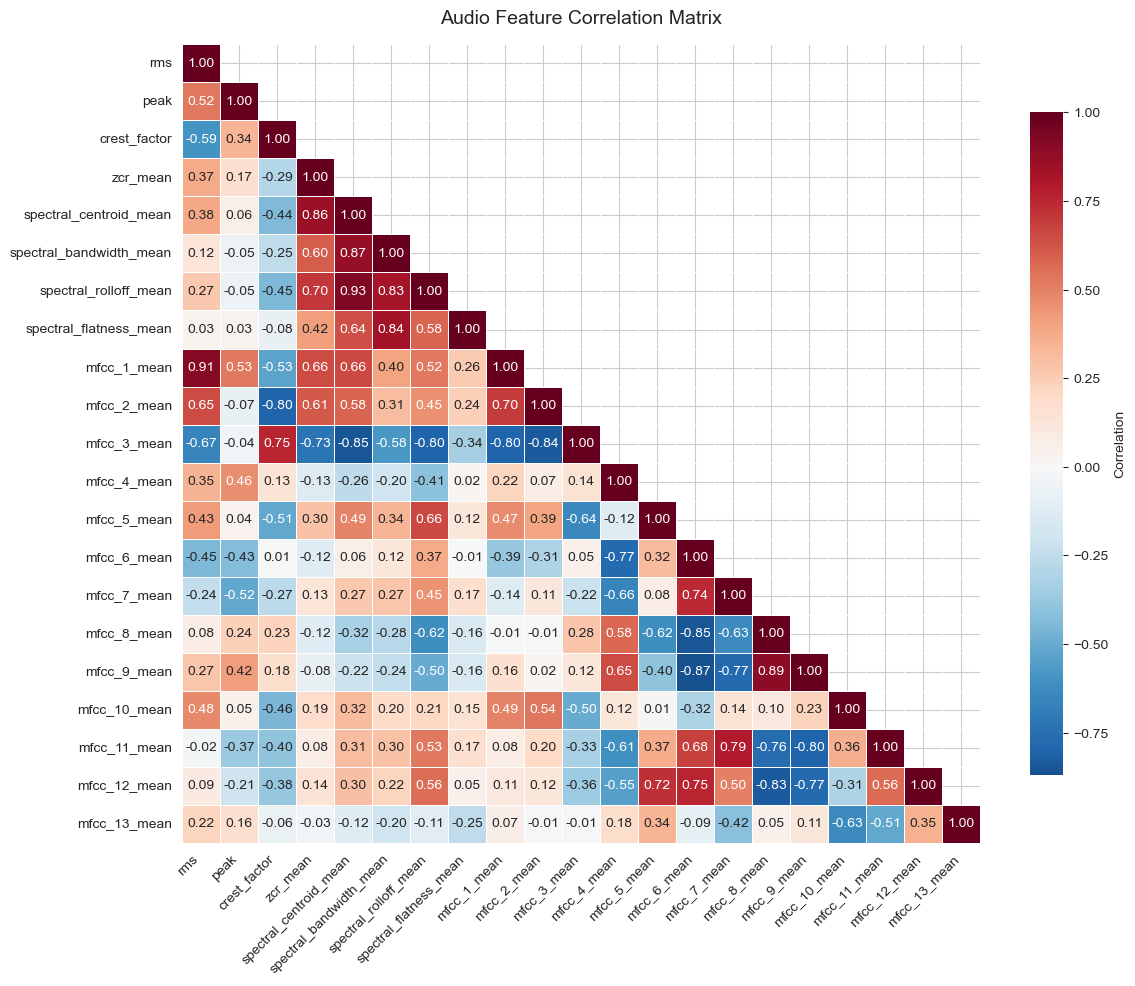

In [24]:
def plot_feature_correlation(features_df: pl.DataFrame):
    """Plot correlation heatmap of audio features."""
    # Select numeric feature columns
    feature_cols = [
        "rms",
        "peak",
        "crest_factor",
        "zcr_mean",
        "spectral_centroid_mean",
        "spectral_bandwidth_mean",
        "spectral_rolloff_mean",
        "spectral_flatness_mean",
    ] + [f"mfcc_{i}_mean" for i in range(1, 14)]  # First 5 MFCCs

    # Filter to existing columns
    existing_cols = [col for col in feature_cols if col in features_df.columns]

    if len(existing_cols) < 2:
        print("Not enough features for correlation analysis")
        return None

    pdf = features_df.select(existing_cols).to_pandas()

    # Compute correlation matrix
    corr_matrix = pdf.corr()

    fig, ax = plt.subplots(figsize=(12, 10))

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0,
        ax=ax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Correlation"},
    )

    ax.set_title("Audio Feature Correlation Matrix", fontsize=14, pad=15)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    return fig


if len(features_df) > 0:
    fig = plot_feature_correlation(features_df)
    plt.show()

In [ ]:
def extract_multichannel_features(
    files_df: pl.DataFrame,
    channels: list[str],
    synonym_map: dict | None = None,
) -> pl.DataFrame:
    """Extract audio features from multiple channels for each file.

    For each channel, features are named as {feature}_{channel_short_name}.
    If a channel doesn't exist, attempts to find it using the synonym lookup table.

    Parameters
    ----------
    files_df : pl.DataFrame
        DataFrame with file paths and metadata
    channels : list[str]
        List of channel names to extract features from (e.g., ["NAWSSound", "Ch_1_labV12", "mic_iso"])
    max_files : int
        Maximum number of files to process
    synonym_map : dict | None
        Mapping from channel names to their synonyms

    Returns
    -------
    pl.DataFrame
        DataFrame with features named as {feature}_{channel} for each channel
    """
    all_features = []

    # Create short names for channels (for column naming)
    def get_short_name(channel: str) -> str:
        """Get a short name for the channel for use in column names."""
        short_names = {
            "NAWSSound": "naws",
            "mic_iso": "mic_iso",
            "mic_2m": "mic_2m",
            "Ch_1_labV12": "sis_trail_k1",
            "Ch_2_labV12": "sis_trail_k2",
            "Ch_3_labV12": "sis_lead_k1",
            "Ch_4_labV12": "sis_lead_k2",
            "TrailK1": "sis_trail_k1",
            "TrailK2": "sis_trail_k2",
            "LeadK1": "sis_lead_k1",
            "LeadK2": "sis_lead_k2",
        }
        return short_names.get(channel, channel.lower().replace(" ", "_"))

    print(f"Extracting features for {len(channels)} channels: {channels}")
    print(f"Processing up to {len(files_df)} files...")

    for row in files_df.iter_rows(named=True):
        file_path = row["file_path"]
        file_features: dict = {
            "file_path": file_path,
            "vehicle": row["vehicle"],
            "tyre_ID": row["tyre_ID"],
            "track_ID": row["track_ID"],
        }

        # Get available channels in this file
        available = get_available_sound_channels(file_path)
        available_names = [c["name"] for c in available]

        channels_found = []

        for channel in channels:
            # Build list of patterns to search for (main + synonyms)
            patterns_to_try = [channel]
            if synonym_map and channel in synonym_map:
                patterns_to_try = synonym_map[channel]

            # Find matching channel in file
            matching_channel = None
            for pattern in patterns_to_try:
                matching = [c for c in available_names if pattern in c]
                if matching:
                    matching_channel = matching[0]
                    break

            if not matching_channel:
                # Channel not available in this file, skip
                continue

            # Extract features for this channel
            channel_features = extract_audio_features(file_path, matching_channel)

            if channel_features:
                # Get short name for column naming
                short_name = get_short_name(channel)
                channels_found.append(short_name)

                # Add features with channel suffix
                for feat_name, feat_value in channel_features.items():
                    file_features[f"{feat_name}_{short_name}"] = feat_value

                # Store which channel was actually used
                file_features[f"channel_used_{short_name}"] = matching_channel

        # Only add if at least one channel was found
        if channels_found:
            file_features["channels_extracted"] = ",".join(channels_found)
            all_features.append(file_features)

    result_df = pl.DataFrame(all_features)

    # Summary
    print(f"\nExtracted features from {len(result_df)} files")
    if len(result_df) > 0:
        print(f"Vehicles: {result_df['vehicle'].unique().to_list()}")
        if "channels_extracted" in result_df.columns:
            channel_counts = result_df["channels_extracted"].value_counts()
            print("Channel combinations found:")
            for row in channel_counts.iter_rows():
                print(f"  {row[0]}: {row[1]} files")

    return result_df


# Example: Extract features from multiple channels
print("=" * 60)
print("Multi-channel feature extraction")
print("=" * 60)

# Define channels to extract (will use synonyms if main name not found)
channels_to_extract = [
    "NAWSSound",
    "mic_iso",
    "mic_2mCh_1_labV12",
    "Ch_2_labV12",
    "Ch_3_labV12",
    "Ch_4_labV12",
    "TrailK1",
    "TrailK2",
    "LeadK1",
    "LeadK2",
]

multichannel_features_df = extract_multichannel_features(
    files_df,
    channels=channels_to_extract,
    synonym_map=CHANNEL_SYNONYMS,
)

# Show sample of columns
print(f"\nTotal columns: {len(multichannel_features_df.columns)}")
print("Sample feature columns:")
for col in sorted(multichannel_features_df.columns)[:20]:
    print(f"  {col}")
if len(multichannel_features_df.columns) > 20:
    print(f"  ... and {len(multichannel_features_df.columns) - 20} more")

multichannel_features_df.head()

Multi-channel feature extraction
Extracting features for 10 channels: ['NAWSSound', 'mic_iso', 'mic_2mCh_1_labV12', 'Ch_2_labV12', 'Ch_3_labV12', 'Ch_4_labV12', 'TrailK1', 'TrailK2', 'LeadK1', 'LeadK2']
Processing up to 204 files...

Extracted features from 204 files
Vehicles: ['04 VW eGolf', '01 VW ID4', '02 Audi Q8', '03 Porsche Taycan']
Channel combinations found:
  naws,mic_iso: 36 files
  naws: 53 files
  mic_iso,sis_trail_k2,sis_lead_k1,sis_lead_k2,sis_trail_k1,sis_trail_k2,sis_lead_k1,sis_lead_k2: 5 files
  naws,mic_iso,sis_trail_k2,sis_lead_k1,sis_lead_k2,sis_trail_k1,sis_trail_k2,sis_lead_k1,sis_lead_k2: 110 files

Total columns: 221
Sample feature columns:
  channel_used_mic_iso
  channel_used_naws
  channel_used_sis_lead_k1
  channel_used_sis_lead_k2
  channel_used_sis_trail_k1
  channel_used_sis_trail_k2
  channels_extracted
  crest_factor_mic_iso
  crest_factor_naws
  crest_factor_sis_lead_k1
  crest_factor_sis_lead_k2
  crest_factor_sis_trail_k1
  crest_factor_sis_trail_k

file_path,vehicle,tyre_ID,track_ID,rms_naws,peak_naws,crest_factor_naws,zcr_mean_naws,spectral_centroid_mean_naws,spectral_centroid_std_naws,spectral_bandwidth_mean_naws,spectral_rolloff_mean_naws,spectral_flatness_mean_naws,mfcc_1_mean_naws,mfcc_1_std_naws,mfcc_2_mean_naws,mfcc_2_std_naws,mfcc_3_mean_naws,mfcc_3_std_naws,mfcc_4_mean_naws,mfcc_4_std_naws,mfcc_5_mean_naws,mfcc_5_std_naws,mfcc_6_mean_naws,mfcc_6_std_naws,mfcc_7_mean_naws,mfcc_7_std_naws,mfcc_8_mean_naws,mfcc_8_std_naws,mfcc_9_mean_naws,mfcc_9_std_naws,mfcc_10_mean_naws,mfcc_10_std_naws,mfcc_11_mean_naws,mfcc_11_std_naws,mfcc_12_mean_naws,mfcc_12_std_naws,…,channel_used_sis_lead_k2,rms_sis_trail_k1,peak_sis_trail_k1,crest_factor_sis_trail_k1,zcr_mean_sis_trail_k1,spectral_centroid_mean_sis_trail_k1,spectral_centroid_std_sis_trail_k1,spectral_bandwidth_mean_sis_trail_k1,spectral_rolloff_mean_sis_trail_k1,spectral_flatness_mean_sis_trail_k1,mfcc_1_mean_sis_trail_k1,mfcc_1_std_sis_trail_k1,mfcc_2_mean_sis_trail_k1,mfcc_2_std_sis_trail_k1,mfcc_3_mean_sis_trail_k1,mfcc_3_std_sis_trail_k1,mfcc_4_mean_sis_trail_k1,mfcc_4_std_sis_trail_k1,mfcc_5_mean_sis_trail_k1,mfcc_5_std_sis_trail_k1,mfcc_6_mean_sis_trail_k1,mfcc_6_std_sis_trail_k1,mfcc_7_mean_sis_trail_k1,mfcc_7_std_sis_trail_k1,mfcc_8_mean_sis_trail_k1,mfcc_8_std_sis_trail_k1,mfcc_9_mean_sis_trail_k1,mfcc_9_std_sis_trail_k1,mfcc_10_mean_sis_trail_k1,mfcc_10_std_sis_trail_k1,mfcc_11_mean_sis_trail_k1,mfcc_11_std_sis_trail_k1,mfcc_12_mean_sis_trail_k1,mfcc_12_std_sis_trail_k1,mfcc_13_mean_sis_trail_k1,mfcc_13_std_sis_trail_k1,channel_used_sis_trail_k1
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
"""/Users/moritzfeik/Developer/RO…","""01 VW ID4""",3,259,48.837498,497.099457,10.178643,0.014754,711.85866,319.293342,1481.98027,1236.034292,0.000348,311.844086,22.523678,176.147644,11.096829,36.256508,8.620258,-9.368888,9.229671,7.296813,4.720477,20.888071,5.347328,14.458863,4.639825,-0.939304,4.023508,-1.74401,4.880556,14.423641,4.611895,14.953197,5.068142,-3.024609,3.897154,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""/Users/moritzfeik/Developer/RO…","""01 VW ID4""",3,259,51.683064,490.063293,9.482087,0.014703,711.048297,255.650989,1469.371885,1213.103342,0.000219,312.26123,25.418087,181.037552,11.877851,31.724426,10.712606,-10.993505,8.609469,6.563178,4.734933,17.910786,5.386881,13.382714,4.795195,-1.144074,4.26625,-2.272877,5.751657,15.308149,4.90737,15.110988,4.899568,-4.075939,4.586079,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""/Users/moritzfeik/Developer/RO…","""01 VW ID4""",3,259,52.256447,464.675262,8.892209,0.016534,791.137383,364.615369,1569.862668,1397.608634,0.000496,326.121765,30.04073,183.43277,15.287325,27.786638,10.3426,-10.149303,10.084068,8.315524,5.07388,18.921959,5.322119,14.833046,4.740658,-0.333009,4.426744,-3.384192,5.908826,13.948659,5.312483,14.891521,5.731494,-3.580454,4.627521,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""/Users/moritzfeik/Developer/RO…","""01 VW ID4""",3,259,48.978508,440.004669,8.983627,0.014882,730.25919,320.580104,1512.256271,1252.948836,0.000349,311.384521,25.949528,177.376938,11.427788,35.208763,8.69754,-10.089817,8.45843,6.524233,4.685372,20.179773,5.438761,14.306663,4.689958,-1.137843,4.515921,-2.410248,5.106568,14.251074,4.450607,15.64658,4.513173,-2.293032,4.245201,…,null,null,null,null,null,nul

Computing correlation matrix for 210 features...


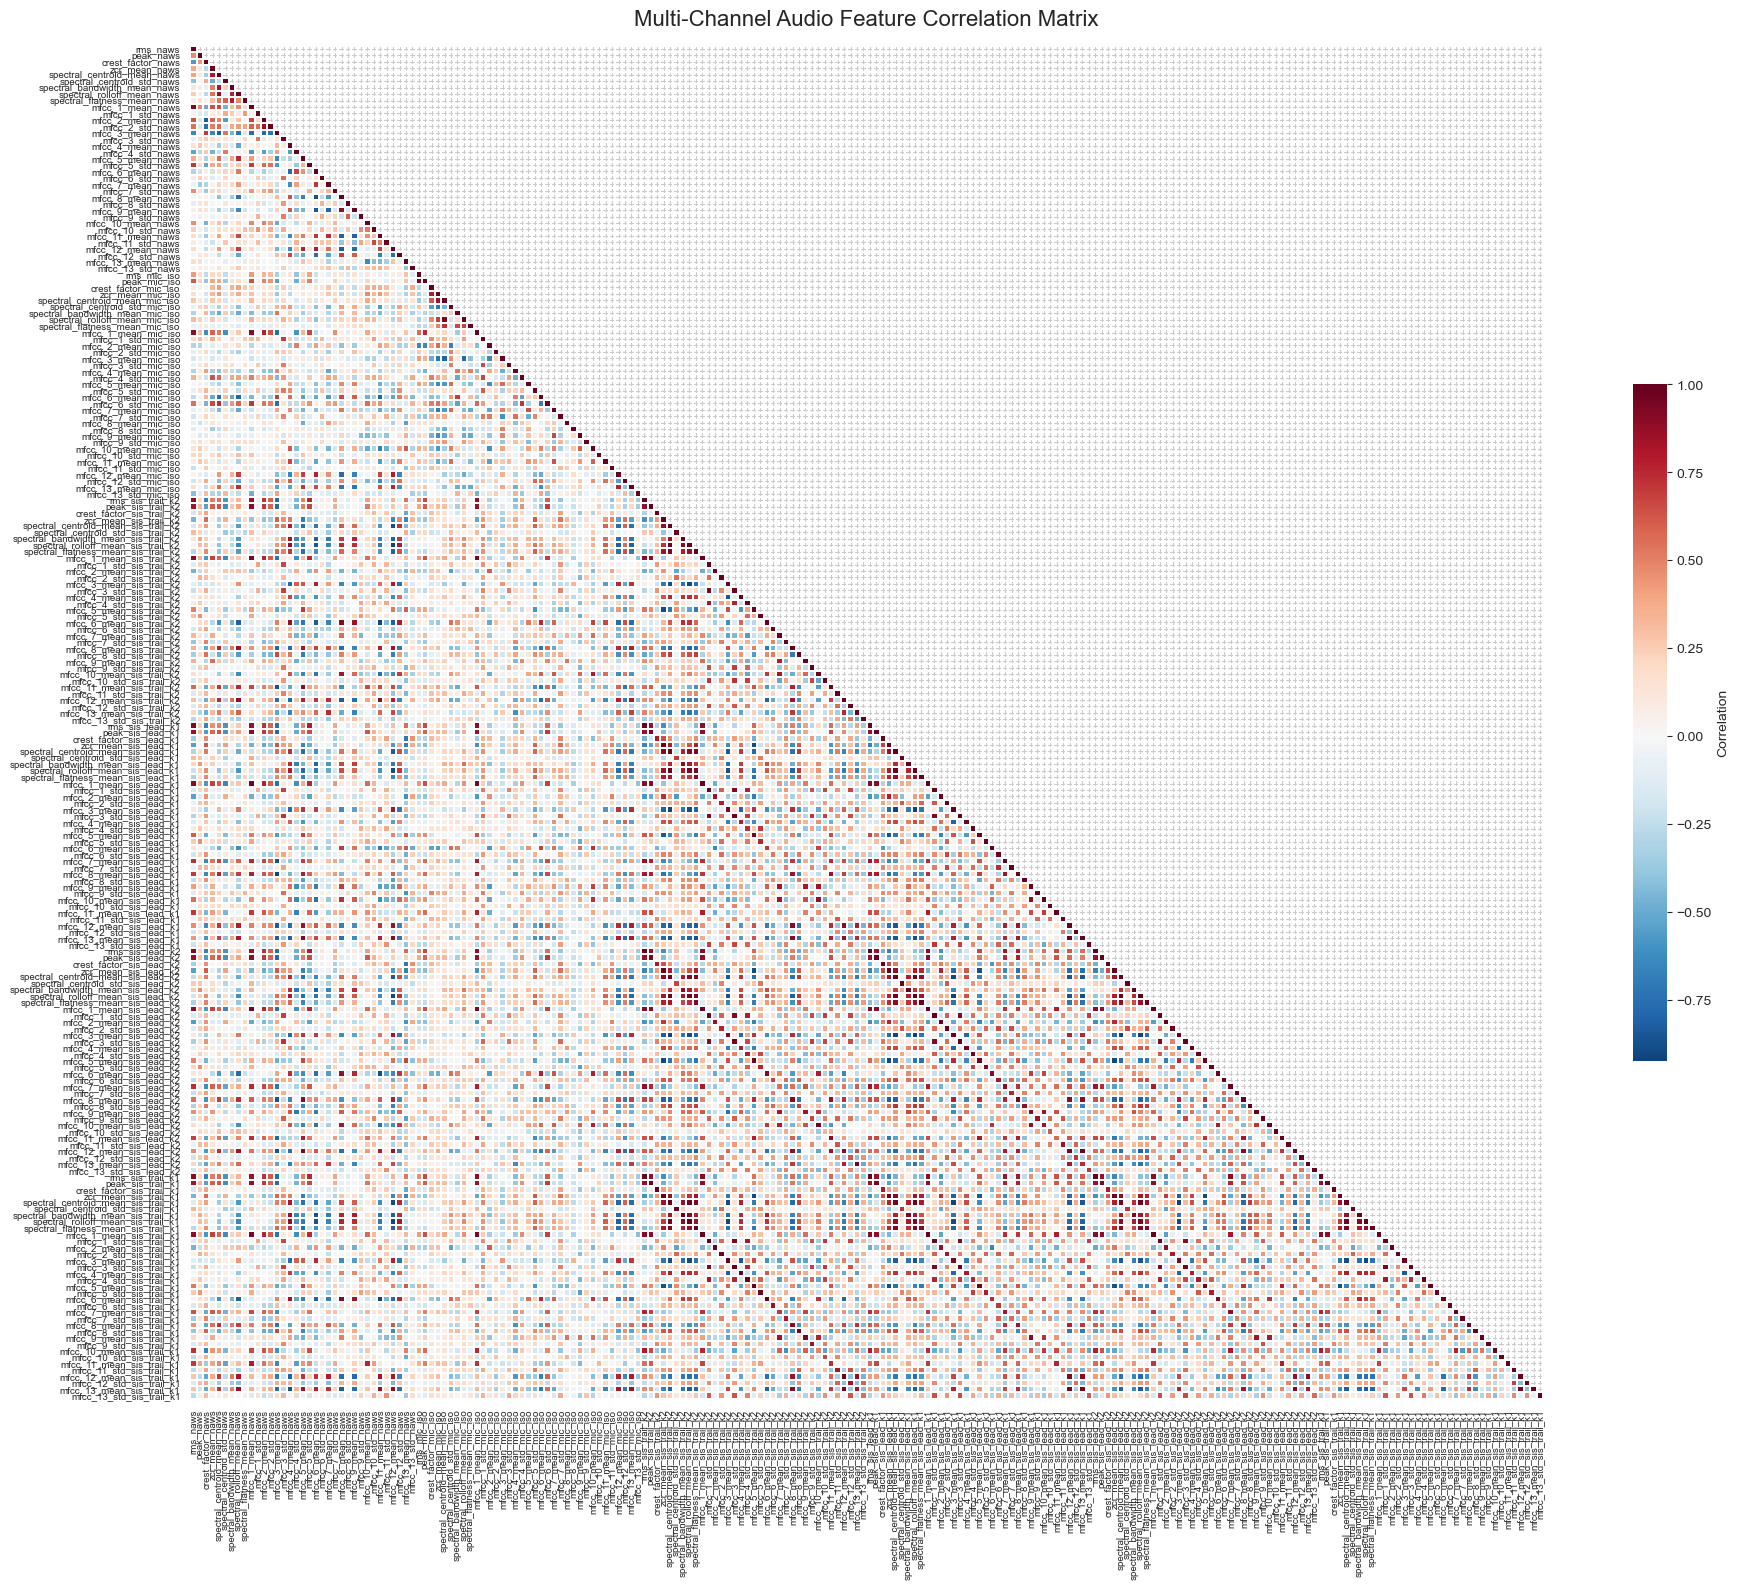


Strongest cross-channel correlations (|r| > 0.8):
  mfcc_1_mean_naws <-> mfcc_1_mean_sis_trail_k1: 0.945
  mfcc_1_mean_mic_iso <-> mfcc_1_mean_sis_trail_k1: 0.935
  mfcc_1_mean_naws <-> mfcc_1_mean_mic_iso: 0.913
  mfcc_11_mean_naws <-> mfcc_6_mean_sis_trail_k1: -0.912
  mfcc_8_mean_naws <-> mfcc_6_mean_sis_trail_k1: 0.910
  mfcc_12_mean_naws <-> spectral_rolloff_mean_sis_trail_k1: -0.907
  rms_naws <-> mfcc_1_mean_sis_trail_k1: 0.892
  rms_naws <-> rms_sis_trail_k1: 0.891
  mfcc_12_mean_naws <-> mfcc_13_mean_sis_trail_k1: 0.891
  mfcc_12_mean_naws <-> spectral_centroid_mean_sis_trail_k1: -0.888
  mfcc_1_mean_naws <-> peak_sis_trail_k1: 0.887
  rms_naws <-> mfcc_1_mean_mic_iso: 0.884
  mfcc_1_mean_mic_iso <-> rms_sis_trail_k1: 0.880
  mfcc_4_mean_naws <-> spectral_rolloff_mean_sis_trail_k1: 0.880
  mfcc_11_mean_naws <-> mfcc_13_mean_sis_trail_k1: 0.871


In [41]:
# Correlation analysis for multi-channel features
def plot_multichannel_correlation(features_df: pl.DataFrame, figsize: tuple = (20, 16)):
    """Plot correlation heatmap for multi-channel audio features."""

    # Get all numeric feature columns (exclude metadata)
    exclude_cols = ["file_path", "vehicle", "tyre_ID", "track_ID", "channels_extracted"]
    exclude_patterns = ["channel_used_"]

    feature_cols = []
    for col in features_df.columns:
        if col in exclude_cols:
            continue
        if any(pattern in col for pattern in exclude_patterns):
            continue
        # Check if column is numeric
        if features_df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
            feature_cols.append(col)

    print(f"Computing correlation matrix for {len(feature_cols)} features...")

    # Convert to pandas for correlation
    pdf = features_df.select(feature_cols).to_pandas()

    # Drop columns with all NaN
    pdf = pdf.dropna(axis=1, how="all")

    # Compute correlation matrix
    corr_matrix = pdf.corr()

    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap (no annotations due to size)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap="RdBu_r",
        center=0,
        ax=ax,
        square=True,
        linewidths=0.1,
        cbar_kws={"shrink": 0.5, "label": "Correlation"},
        xticklabels=True,
        yticklabels=True,
    )

    ax.set_title("Multi-Channel Audio Feature Correlation Matrix", fontsize=16, pad=15)
    plt.xticks(rotation=90, ha="center", fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()

    return fig, corr_matrix


# Plot correlation for all multi-channel features
if len(multichannel_features_df) > 0:
    fig, corr_matrix = plot_multichannel_correlation(multichannel_features_df)
    plt.show()

    # Show strongest cross-channel correlations
    print("\n" + "=" * 60)
    print("Strongest cross-channel correlations (|r| > 0.8):")
    print("=" * 60)

    # Find cross-channel correlations
    channels = ["naws", "sis_trail_k1", "mic_iso"]
    cross_correlations = []

    for i, col1 in enumerate(corr_matrix.columns):
        for j, col2 in enumerate(corr_matrix.columns):
            if i >= j:  # Skip diagonal and lower triangle
                continue

            # Check if columns are from different channels
            ch1 = None
            ch2 = None
            for ch in channels:
                if col1.endswith(f"_{ch}"):
                    ch1 = ch
                if col2.endswith(f"_{ch}"):
                    ch2 = ch

            if ch1 and ch2 and ch1 != ch2:
                corr_val = corr_matrix.loc[col1, col2]
                if abs(corr_val) > 0.8:  # type: ignore
                    cross_correlations.append((col1, col2, corr_val))

    # Sort by absolute correlation
    cross_correlations.sort(key=lambda x: abs(x[2]), reverse=True)

    for col1, col2, corr_val in cross_correlations[:15]:
        print(f"  {col1} <-> {col2}: {corr_val:.3f}")

## 11. Summary

### Key Sound-Related Features in the Dataset:

1. **NAWSSound**: Near-field acoustic wave sensor measurements - captures close-range tyre noise
2. **mic_iso**: ISO standard pass-by noise measurements - regulatory relevant
3. **SIS Sensors (Ch_1-4_labV12)**: Leading/Trailing edge measurements for tyre deformation sounds

### Analysis Techniques Applied:

1. **Time Domain**: Raw waveform visualization showing amplitude variations
2. **Frequency Spectrum (FFT)**: Identifies dominant frequencies in tyre noise
3. **Spectrogram**: Time-frequency representation showing how noise content evolves
4. **MFCC**: Perceptually-motivated features useful for noise characterization and ML
5. **Mel Spectrogram**: Human hearing-weighted frequency representation
6. **1/3 Octave Bands**: Standard acoustic analysis for regulatory compliance
7. **Feature Correlation**: Understanding relationships between different acoustic measures

### Observations:
- Tyre noise is broadband with energy typically concentrated in 200-2000 Hz range
- Different tyres and vehicles show distinct spectral signatures
- MFCC features capture perceptually relevant differences between measurements
- Spectral features like centroid and bandwidth are useful discriminators